# Searching for correlations in 'The Simpsons TV show' 

### The goal is to identify quantitative variables that may be correlated with the quality of the show.

##### To evaluate the performance of each episode, we will analyze their IMDb scores and examine how episodes have evolved over time. We have all the required data in CSV files, which includes details about locations, characters, and the emotions expressed in each line of the TV show. Despite my belief that these variables may not strongly correlate with the quality of the show, let's proceed to explore the insights we can uncover!

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from adjustText import adjust_text
import seaborn as sns
import numpy as np
import squarify
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [6]:
script_lines_df = pd.read_csv(r'cvs_files\script_lines.csv')
location_df = pd.read_csv(r'cvs_files\locations.csv')
episode_df = pd.read_csv(r'cvs_files\episodes.csv')
character_df = pd.read_csv(r'cvs_files\characters.csv')
emotional_lines_df = pd.read_csv(r'cvs_files\emotional_dataframe.csv')
binomial_emotion_result = pd.read_csv(r'cvs_files\emotional_binomial_result.csv')


In [7]:
#for some particular reason the script_lines file came incomplete after season 22
script_lines_df = script_lines_df[script_lines_df['season'] <= 22]

In [8]:
emotional_lines_df.head(2)

emotional_id   neutral  disapproval  annoyance  disappointment  approval  \
0         86263  0.013570     0.014384   0.006634        0.035880  0.067097   
1         86264  0.594302     0.003356   0.016335        0.007102  0.012534   

   realization     anger    desire   sadness  ...   disgust    relief  \
0     0.016827  0.005142  0.004853  0.243649  ...  0.004861  0.004990   
1     0.011262  0.004460  0.001880  0.003631  ...  0.015420  0.001709   

   embarrassment      love      fear  gratitude  nervousness     grief  \
0       0.008168  0.101742  0.002450   0.023776     0.002164  0.012175   
1       0.005707  0.005331  0.007303   0.001092     0.001702  0.001407   

    remorse     pride  
0  0.594076  0.005640  
1  0.000461  0.002112  

[2 rows x 29 columns]

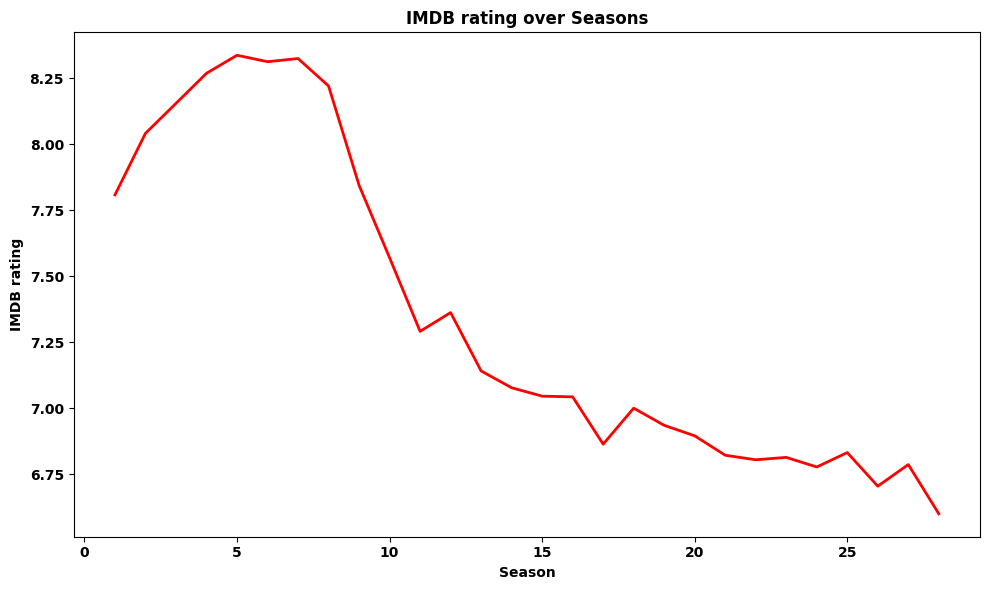

In [9]:
#Lets see how de 'imdb_rating' went during the seasons

average_ratings = episode_df.groupby('season')['imdb_rating'].mean()

plt.figure(figsize=(10, 6))

plt.plot(average_ratings.index, average_ratings.values, linestyle='-', color='r', linewidth=2)

plt.grid(False)

plt.xlabel('Season')
plt.ylabel('IMDB rating')
plt.title('IMDB rating over Seasons')

plt.tight_layout()
plt.show()


#### It's not a big surprise that the show declined in quality during later seasons!
#### Now the question is... 
### - "Does the variation in character appearances have something to do with it?"

In [10]:
# this will use a df of how much the characteres appear in the show

character_id_counts = script_lines_df['character_id'].value_counts()

total_rows = len(script_lines_df)

character_id_percentages = (character_id_counts / total_rows) * 100

character_id_percentage_df = pd.DataFrame({'character_id': character_id_percentages.index, 'appearance_percentage': character_id_percentages.values})

character_id_percentage_df = pd.merge(character_id_percentage_df, character_df[['id', 'name', 'normalized_name','gender']], left_on='character_id', right_on='id', how='left')

character_id_percentage_df.drop(columns=['id'], inplace=True)

character_id_percentage_df.sort_values(by='appearance_percentage', ascending=False, inplace=True)

character_id_percentage_df.head(2)


character_id  appearance_percentage           name normalized_name  gender
0           2.0              19.077144  Homer Simpson   homer simpson    male
1           1.0               8.974246  Marge Simpson   marge simpson  female

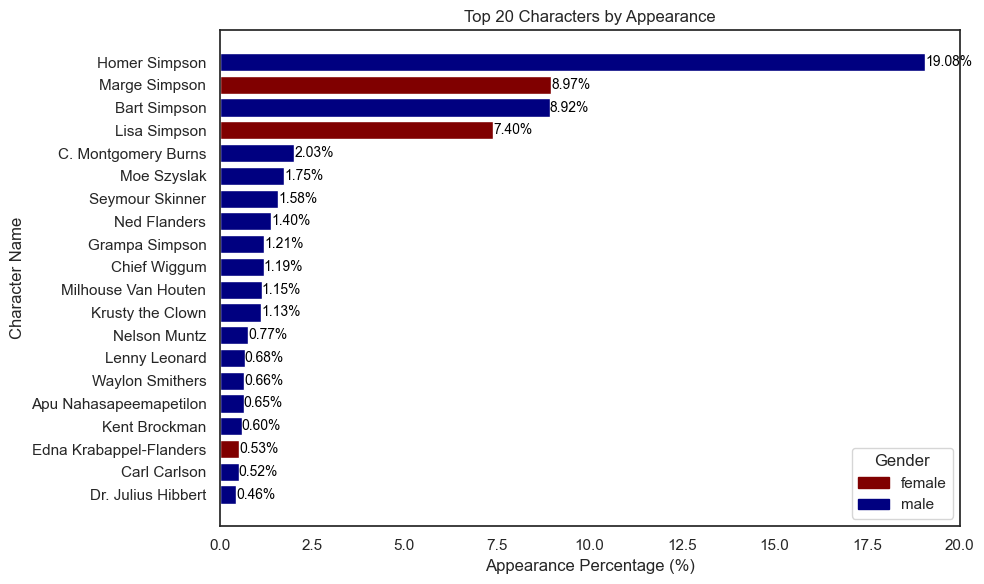

In [85]:
top_20_characters = character_id_percentage_df.head(20)
color_mapping = {'female': 'maroon', 'male': 'navy'}

plt.figure(figsize=(10, 6))

bars = plt.barh(top_20_characters['name'], top_20_characters['appearance_percentage'], 
                color=top_20_characters['gender'].map(color_mapping))

plt.xlabel('Appearance Percentage (%)')
plt.ylabel('Character Name')
plt.title('Top 20 Characters by Appearance')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', 
             va='center', ha='left', color='black', fontsize=10)

plt.gca().invert_yaxis()

handles = [plt.Rectangle((0,0),1,1, color=color_mapping[label]) for label in color_mapping]
labels = color_mapping.keys()
legend = plt.legend(handles, labels, loc='lower right', title='Gender')

legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.show()

#### It's amazing that Homer appears more than double the amount of times compared to the rest of the family.
#### on the other hand most of the main characters a men.

#### We're still missing some gender values, but we'll manage with what we have. We don't need that many.
##### With over 6000 entries, it's too many to analyze comprehensively. Let's focus on the top 50 characters and start investigating their correlation with IMDb ratings.

In [12]:
top30_characters_percentage_df = character_id_percentage_df.dropna(subset=['gender']).head(30)
top30_characters_percentage_df.head(4)

character_id  appearance_percentage           name normalized_name  gender
0           2.0              19.077144  Homer Simpson   homer simpson    male
1           1.0               8.974246  Marge Simpson   marge simpson  female
2           8.0               8.923677   Bart Simpson    bart simpson    male
3           9.0               7.401463   Lisa Simpson    lisa simpson  female

#### In the next function, we will create a DataFrame that checks the proportion of participation that every character had in each episode.
#### To do this, I analyzed how many lines each character had compared to the total lines in the episode.

In [13]:
def calculate_variable_percentages(script_lines_df, character_df, episode_df, top_characters_df):
    """
    Calculates the percentage of script lines has to each character (or location) in each episode.

    """
    freq = script_lines_df.groupby(['episode_id', 'character_id']).size().reset_index(name='frequency')

    pivot_freq = freq.pivot(index='episode_id', columns='character_id', values='frequency').fillna(0)

    total_x_episode = freq.groupby('episode_id')['frequency'].sum()
  
    pivot_freq_proportions = pivot_freq.div(total_x_episode, axis=0)

    pivot_freq_proportions.columns = [character_id for character_id in pivot_freq_proportions.columns]

    character_map = character_df.set_index('id')['normalized_name'].to_dict()

    pivot_freq_proportions.rename(columns=character_map, inplace=True)

    columns_to_drop = [col for col in pivot_freq_proportions.columns if col not in top_characters_df['normalized_name'].values]

    pivot_freq_proportions.drop(columns=columns_to_drop, inplace=True)

    pivot_freq_proportions.reset_index(inplace=True)

    pivot_freq_proportions.rename_axis(None, axis=1, inplace=True)

    percentages_of_lines_character = pd.merge(pivot_freq_proportions, episode_df[['us_viewers_in_millions', 'imdb_rating']], left_on='episode_id', right_index=True)

    return percentages_of_lines_character



In [14]:
percentages_of_lines_character = calculate_variable_percentages(script_lines_df, character_df, episode_df, top30_characters_percentage_df)
percentages_of_lines_character.head(5)

episode_id  marge simpson  homer simpson  seymour skinner  bart simpson  \
0           1       0.126471       0.344118         0.008824      0.150000   
1           2       0.083942       0.208029         0.065693      0.299270   
2           3       0.070755       0.278302         0.000000      0.155660   
3           4       0.132686       0.268608         0.000000      0.139159   
4           5       0.058824       0.114187         0.020761      0.352941   

   lisa simpson  patty bouvier  ned flanders  waylon smithers  \
0      0.061765       0.047059      0.020588         0.005882   
1      0.036496       0.000000      0.000000         0.000000   
2      0.051887       0.000000      0.000000         0.037736   
3      0.113269       0.000000      0.000000         0.029126   
4      0.096886       0.000000      0.000000         0.000000   

   c montgomery burns  ...  lenny leonard  carl carlson  \
0            0.008824  ...            0.0           0.0   
1            0.000000  ...            0.0           0.0   
2            0.061321  ...            0.0           0.0   
3            0.058252  ...            0.0           0.0   
4            0.000000  ...            0.0           0.0   

   apu nahasapeemapetilon  kent brockman  mayor joe quimby  dr julius hibbert  \
0                     0.0            0.0               0.0                0.0   
1                     0.0            0.0               0.0                0.0   
2                     0.0            0.0               0.0                0.0   
3                     0.0            0.0               0.0                0.0   
4                     0.0            0.0               0.0                0.0   

   groundskeeper willie  comic book guy  us_viewers_in_millions  imdb_rating  
0                   0.0             0.0                    30.4          8.3  
1                   0.0             0.0                    33.6          8.2  
2                   0.0             0.0                    26.1          8.1  
3                   0.0             0.0                    25.4          8.0  
4                   0.0             0.0                    26.2          8.4  

[5 rows x 33 columns]

#### Now we are going to create a function that gives us a DataFrame with the correlation between variables, which we can use later in a heatmap

In [15]:
def calculate_item_percentage_per_episode(character_id_col, character_df, top_characters_percentage_df, script_lines_df, episode_df):
    # Calculate the frequency of occurrence of 'character_id' by 'episode_id'
    freq = script_lines_df.groupby(['episode_id', character_id_col]).size().reset_index(name='frequency')

    # Pivot the DataFrame to have 'character_id' as columns and 'frequency' as values.
    pivot_freq = freq.pivot(index='episode_id', columns=character_id_col, values='frequency').fillna(0)

    # Calculate the proportions by dividing by the total 'frequency' for each 'episode_id'
    total_x_episode = freq.groupby('episode_id')['frequency'].sum()
    pivot_freq_proportions = pivot_freq.div(total_x_episode, axis=0)

    # Change the column names to include 'frequency' and the value of 'character_id'.
    pivot_freq_proportions.columns = [character_id for character_id in pivot_freq_proportions.columns]

    # Create a mapping dictionary between 'character_id' and 'normalized_name'
    character_map = character_df.set_index('id')['normalized_name'].to_dict()

    # Change the column names in pivot_freq_proportions using the mapping
    pivot_freq_proportions.rename(columns=character_map, inplace=True)

    # Filter columns to include only relevant characters
    pivot_freq_proportions = pivot_freq_proportions[top_characters_percentage_df['normalized_name'].values]

    # Reset the index to get 'episode_id' as a column and keep it named as 'episode_id'
    pivot_freq_proportions.reset_index(inplace=True)

    # Rename the index column to 'episode_id'
    pivot_freq_proportions.rename_axis(None, axis=1, inplace=True)

    # Merge the episode_df with pivot_freq_proportions using 'id' and 'episode_id'
    proportion_df = pd.merge(pivot_freq_proportions, episode_df[['us_viewers_in_millions', 'imdb_rating']], left_on='episode_id', right_index=True)

    # Calculate correlation matrix
    correlation_matrix = proportion_df.corr()

    return correlation_matrix


In [16]:
character_30_proportion_df = calculate_item_percentage_per_episode('character_id', character_df, top30_characters_percentage_df,script_lines_df, episode_df)
character_30_proportion_df.head(3)

episode_id  homer simpson  marge simpson  bart simpson  \
episode_id       1.000000      -0.092802       0.007750     -0.159978   
homer simpson   -0.092802       1.000000       0.193411     -0.344110   
marge simpson    0.007750       0.193411       1.000000     -0.128600   

               lisa simpson  c montgomery burns  moe szyslak  seymour skinner  \
episode_id         0.082038           -0.117277     0.101628         0.004275   
homer simpson     -0.245377           -0.004002     0.030578        -0.326859   
marge simpson     -0.103571           -0.134556    -0.045326        -0.192045   

               ned flanders  grampa simpson  ...  sideshow bob  \
episode_id         0.029875       -0.037551  ...     -0.053176   
homer simpson      0.069032       -0.075181  ...     -0.137659   
marge simpson     -0.054575       -0.106829  ...     -0.086915   

               groundskeeper willie  rev timothy lovejoy  ralph wiggum  \
episode_id                 0.064194            -0.036852     -0.001398   
homer simpson             -0.156682            -0.021907     -0.220169   
marge simpson             -0.091984             0.078632     -0.107114   

               mayor joe quimby  patty bouvier  otto mann  comic book guy  \
episode_id             0.002449      -0.093809  -0.059869        0.117686   
homer simpson         -0.055507       0.001186  -0.083438       -0.068938   
marge simpson         -0.087226       0.071000  -0.001791       -0.086489   

               us_viewers_in_millions  imdb_rating  
episode_id                  -0.343892    -0.319375  
homer simpson                0.109518     0.097886  
marge simpson                0.071743     0.045146  

[3 rows x 33 columns]

<Figure size 1600x1200 with 0 Axes>

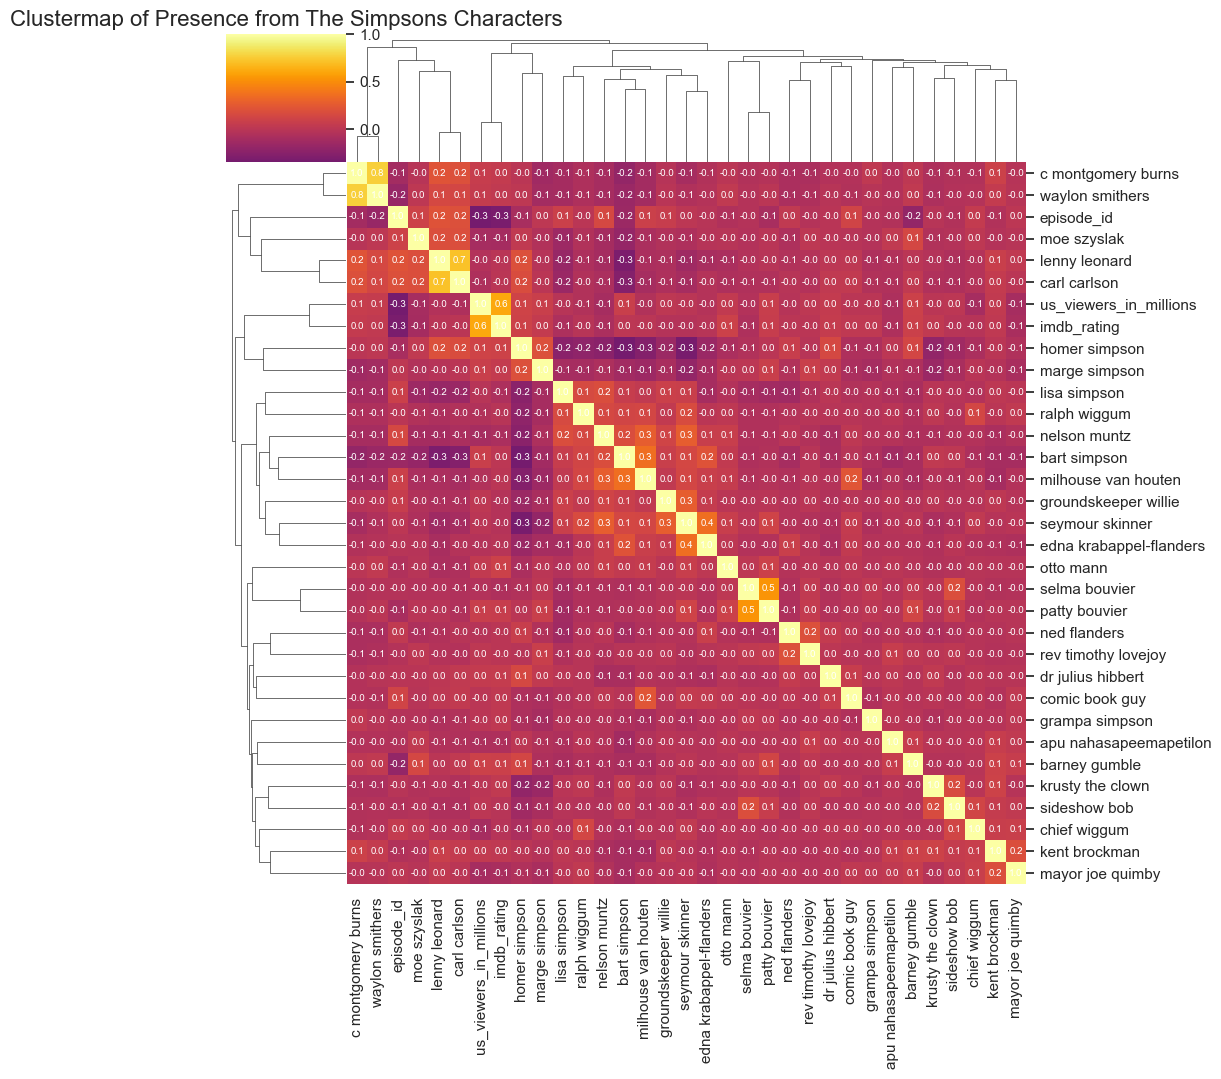

In [132]:
plt.figure(figsize=(16, 12))

character_cluster = sns.clustermap(character_30_proportion_df,
                    annot=True,
                    fmt=".1f",
                    annot_kws={"fontsize": 7, "color": "white", "ha": "center", "va": "center"},                 
                    cmap="inferno",
                    cbar=True,
                    center=0,
                    dendrogram_ratio=(0.15,0.15),
                    row_cluster=True,
                    col_cluster=True,
                    xticklabels=1)

character_cluster.ax_heatmap.figure.axes[-1].set_position([-0.15, 0.5, 0.05, 0.5]) 

plt.title('Clustermap of Presence from The Simpsons Characters', fontsize=16)
plt.xlabel('', fontsize=8)
plt.ylabel('', fontsize=8)
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1)
plt.show()

#### Observations from the Heatmap:
- It appears that none of the 30 main characters have a strong correlation with the overall quality of the show (as measured by IMDb rating).
- Notably, in the heatmap, 'imdb_rating' and 'episode_id' do not exhibit strong correlations (lower than 0.5) except with each other.
- Other strong correlations we identified include:
  - Lenny and Carl (often considered sidekicks)
  - Skinner and Chalmers
  - Patty and Selma
- Additionally, the cluster groups the school kids on the bright side (top right), which aligns well with the narrative.


#### OK, we will use the Pearson function to determine significance for every character.

In [18]:
def calculate_pearson_correlations(df, target_column):

    df = df.copy()

    correlation_results = []

    for column in df.columns:  
        if column != target_column:
            
            df.loc[:, column] = df[column].fillna(0)

            df_cleaned = df.dropna(subset=[target_column])

            r, p_value = pearsonr(df_cleaned[column], df_cleaned[target_column])
            r_squared = r**2

            row_count = df_cleaned[df_cleaned[column] != 0][column].count()

            p_value_significant = p_value < 0.10

            if not pd.isnull(r):
                correlation_results.append({'variables': column, 'times_appear': row_count, 'r': r, 'r^2': r_squared, 'p_value': p_value, 'p_value_significant': p_value_significant})

    correlation_df = pd.DataFrame(correlation_results)

    return correlation_df

##### Lets see the relation whith 'imdb_rating'

- the 'p_value_significant' means that 'p_value' is less of 0.10 so it means that there correlation is not explain by randomness. 

In [19]:
character_correlation_imdb_df = calculate_pearson_correlations(percentages_of_lines_character,'imdb_rating')

character_correlation_imdb_df.sort_values(by='r', ascending=False)

variables  times_appear         r       r^2       p_value  \
31   us_viewers_in_millions           477  0.585896  0.343274  1.403950e-45   
2             homer simpson           480  0.097886  0.009582  3.202249e-02   
16                otto mann           119  0.087866  0.007720  5.438648e-02   
11            barney gumble           166  0.084446  0.007131  6.451448e-02   
6             patty bouvier            94  0.062177  0.003866  1.738337e-01   
28        dr julius hibbert           179  0.054409  0.002960  2.341156e-01   
9        c montgomery burns           207  0.049513  0.002452  2.789846e-01   
1             marge simpson           479  0.045146  0.002038  3.236265e-01   
8           waylon smithers           154  0.033589  0.001128  4.628392e-01   
20         krusty the clown           206  0.028194  0.000795  5.377535e-01   
14           grampa simpson           221  0.021460  0.000461  6.390689e-01   
30           comic book guy           102  0.020648  0.000426  6.518210e-01   
26            kent brockman           203  0.018509  0.000343  6.858584e-01   
4              bart simpson           479  0.003392  0.000012  9.409110e-01   
24             carl carlson           231 -0.002219  0.000005  9.613290e-01   
21      rev timothy lovejoy           111 -0.002860  0.000008  9.501592e-01   
13      milhouse van houten           266 -0.006638  0.000044  8.846701e-01   
7              ned flanders           240 -0.007161  0.000051  8.756477e-01   
23            lenny leonard           265 -0.008311  0.000069  8.558884e-01   
22             sideshow bob            15 -0.022193  0.000493  6.276571e-01   
19             ralph wiggum           164 -0.023191  0.000538  6.122709e-01   
15  edna krabappel-flanders           118 -0.023531  0.000554  6.070659e-01   
17             chief wiggum           268 -0.027038  0.000731  5.545679e-01   
3           seymour skinner           260 -0.029950  0.000897  5.127144e-01   
29     groundskeeper willie           145 -0.032696  0.001069  4.748174e-01   
25   apu nahasapeemapetilon           170 -0.065214  0.004253  1.537048e-01   
12            selma bouvier            93 -0.065430  0.004281  1.523480e-01   
5              lisa simpson           478 -0.071256  0.005077  1.189827e-01   
18             nelson muntz           236 -0.085623  0.007331  6.086820e-02   
27         mayor joe quimby           121 -0.089234  0.007963  5.072321e-02   
10              moe szyslak           318 -0.112238  0.012597  1.387892e-02   
0                episode_id           480 -0.319375  0.102000  7.639991e-13   

    p_value_significant  
31                 True  
2                  True  
16                 True  
11                 True  
6                 False  
28                False  
9                 False  
1                 False  
8                 False  
20                False  
14                False  
30                False  
26                False  
4                 False  
24                False  
21                False  
13                False  
7                 False  
23                False  
22                False  
19                False  
15                False  
17                False  
3                 False  
29                False  
25                False  
12                False  
5                 False  
18                 True  
27                 True  
10                 True  
0                  True

In [20]:
top_character_correlation_imdb_df = character_correlation_imdb_df[character_correlation_imdb_df['p_value_significant'] == True]
top_character_correlation_imdb_df.sort_values(by='r', ascending=False)


variables  times_appear         r       r^2       p_value  \
31  us_viewers_in_millions           477  0.585896  0.343274  1.403950e-45   
2            homer simpson           480  0.097886  0.009582  3.202249e-02   
16               otto mann           119  0.087866  0.007720  5.438648e-02   
11           barney gumble           166  0.084446  0.007131  6.451448e-02   
18            nelson muntz           236 -0.085623  0.007331  6.086820e-02   
27        mayor joe quimby           121 -0.089234  0.007963  5.072321e-02   
10             moe szyslak           318 -0.112238  0.012597  1.387892e-02   
0               episode_id           480 -0.319375  0.102000  7.639991e-13   

    p_value_significant  
31                 True  
2                  True  
16                 True  
11                 True  
18                 True  
27                 True  
10                 True  
0                  True

#### well there are a few characters that pass the validation but they are poorly correlated. ( less than +-0.12)

 - 'us_viewers_in_millions' and 'episode_id' are just ther for referention purpuse

In [21]:

def count_lines_by_season(script_lines_df, character_names):
    num_plots = len(character_names)
    num_rows = 2
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6))

    for i, character_name in enumerate(character_names):
        character_id = character_df.loc[character_df['normalized_name'] == character_name, 'id'].iloc[0]
        filtered_df = script_lines_df[script_lines_df['character_id'] == character_id]

        count_by_season = filtered_df.groupby('season').size().reset_index(name='line_count')
        count_by_season = count_by_season[count_by_season['season'] <= 22]

        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        # Get correlation (r) for the character from top_character_correlation_imdb_df
        correlation_value = top_character_correlation_imdb_df.loc[top_character_correlation_imdb_df['variables'] == character_name, 'r'].values[0]
        determination_value = top_character_correlation_imdb_df.loc[top_character_correlation_imdb_df['variables'] == character_name, 'r^2'].values[0]
        
        # Plot bar chart
        ax.bar(count_by_season['season'], count_by_season['line_count'], color='skyblue')
        ax.set_title(f"{character_name.title()} (r = {correlation_value:.2f}, r^2 = {determination_value:.4f})", fontsize=12)
        ax.set_xlabel('Season Number', fontsize=8)
        ax.set_ylabel('Line Count', fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

        # Plot IMDb ratings on secondary y-axis
        ax2 = ax.twinx()
        average_ratings = episode_df.groupby('season')['imdb_rating'].mean()
        average_ratings = average_ratings[average_ratings.index <= 22]
        ax2.plot(average_ratings.index, average_ratings.values, linestyle='-', color='r', linewidth=2)
        ax2.set_ylabel('IMDB rating', fontsize=8)



    # Remove unused subplots if num_plots < 6
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            axes.flatten()[i].axis('off')

    # Set shared x-axis ticks for all plots
    for ax in axes.flatten():
        ax.set_xticks(np.arange(1, 23, 1))  # Set ticks from 1 to 22
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x):d}'))  # Format tick labels as integers

    fig.suptitle('Correlation between character lines and IMDB rating per season', fontsize= 16)

    episode_correlation_value = top_character_correlation_imdb_df.loc[top_character_correlation_imdb_df['variables'] == 'episode_id', 'r'].values[0]
    episode_determination_value = top_character_correlation_imdb_df.loc[top_character_correlation_imdb_df['variables'] == 'episode_id', 'r^2'].values[0]

    # Include correlation and determination values in the footnote
    footnote_text = f"Values between IMDb and episodes are r = {episode_correlation_value:.2f} and r^2 = {episode_determination_value:.2f}"
    ax.text(0.5, -0.45, footnote_text, fontsize=10, ha='center', transform=ax.transAxes)




    fig.tight_layout()
    plt.show()


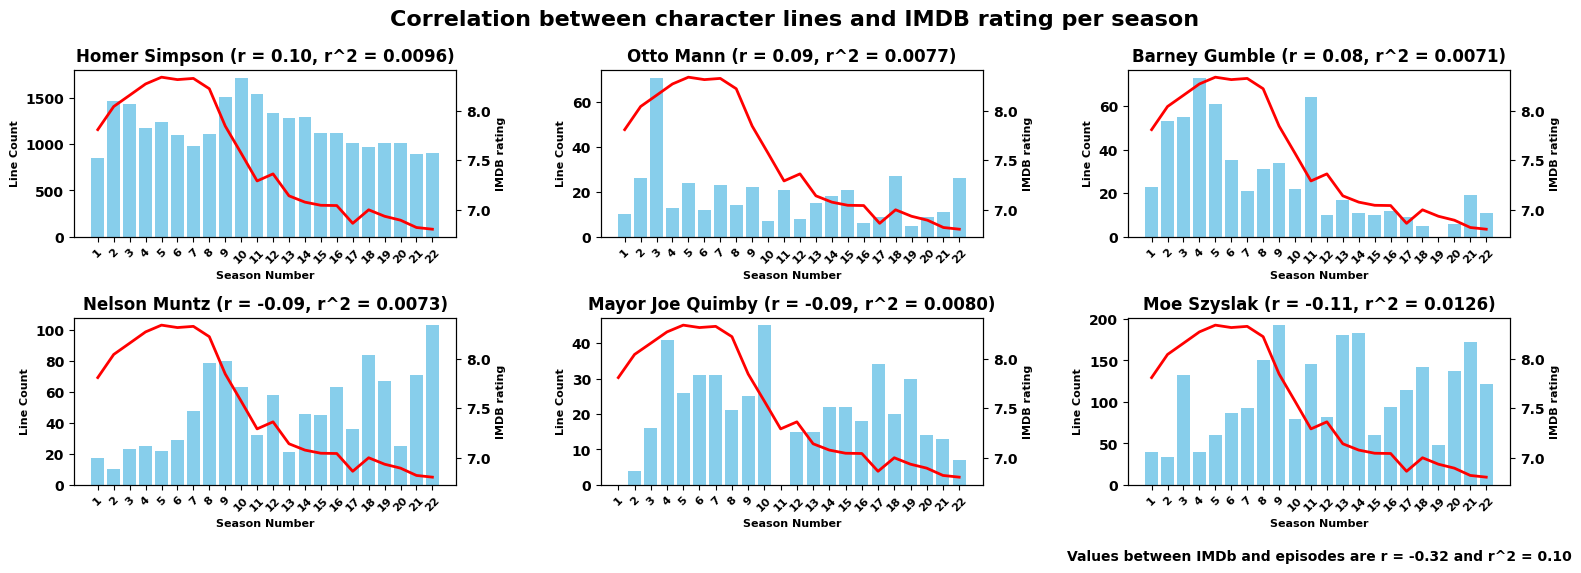

In [22]:

character_names = ['homer simpson', 'otto mann', 'barney gumble','nelson muntz', 'mayor joe quimby', 'moe szyslak']

count_lines_by_season(script_lines_df, character_names)


#### In the chart above shows the characters whith the most significants values an are still, meh. But the graphs kind of helps to see the relation. 

## Ok now lets see if we what we can find correlation between the characters lines over the episodes

In [23]:
character_correlation_episodes_df = calculate_pearson_correlations(percentages_of_lines_character,'episode_id')

character_correlation_episodes_df.sort_values(by='r', ascending=False)

variables  times_appear         r       r^2       p_value  \
22            lenny leonard           267  0.206010  0.042440  4.998173e-06   
23             carl carlson           233  0.190619  0.036336  2.474070e-05   
17             nelson muntz           238  0.146202  0.021375  1.272404e-03   
29           comic book guy           102  0.117686  0.013850  9.633208e-03   
9               moe szyslak           320  0.101628  0.010328  2.551580e-02   
4              lisa simpson           481  0.082038  0.006730  7.164986e-02   
12      milhouse van houten           267  0.082011  0.006726  7.174370e-02   
28     groundskeeper willie           145  0.064194  0.004121  1.589504e-01   
16             chief wiggum           268  0.048186  0.002322  2.905739e-01   
6              ned flanders           242  0.029875  0.000892  5.124629e-01   
0             marge simpson           482  0.007750  0.000060  8.651088e-01   
2           seymour skinner           260  0.004275  0.000018  9.253441e-01   
26         mayor joe quimby           121  0.002449  0.000006  9.571802e-01   
18             ralph wiggum           165 -0.001398  0.000002  9.755479e-01   
27        dr julius hibbert           181 -0.010086  0.000102  8.250161e-01   
14  edna krabappel-flanders           118 -0.014186  0.000201  7.558257e-01   
19         krusty the clown           208 -0.022124  0.000489  6.276639e-01   
11            selma bouvier            93 -0.034614  0.001198  4.478661e-01   
20      rev timothy lovejoy           112 -0.036852  0.001358  4.190423e-01   
13           grampa simpson           223 -0.037551  0.001410  4.102661e-01   
24   apu nahasapeemapetilon           171 -0.047183  0.002226  3.007438e-01   
21             sideshow bob            15 -0.053176  0.002828  2.434277e-01   
25            kent brockman           205 -0.053362  0.002847  2.417822e-01   
15                otto mann           120 -0.059869  0.003584  1.890094e-01   
1             homer simpson           483 -0.092802  0.008612  4.148486e-02   
5             patty bouvier            95 -0.093809  0.008800  3.931603e-02   
8        c montgomery burns           208 -0.117277  0.013754  9.890014e-03   
3              bart simpson           482 -0.159978  0.025593  4.163099e-04   
7           waylon smithers           155 -0.183511  0.033676  4.968165e-05   
10            barney gumble           167 -0.194662  0.037893  1.644889e-05   
31              imdb_rating           480 -0.245830  0.060432  4.427747e-08   
30   us_viewers_in_millions           477 -0.325932  0.106231  2.041182e-13   

    p_value_significant  
22                 True  
23                 True  
17                 True  
29                 True  
9                  True  
4                  True  
12                 True  
28                False  
16                False  
6                 False  
0                 False  
2                 False  
26                False  
18                False  
27                False  
14                False  
19                False  
11                False  
20                False  
13                False  
24                False  
21                False  
25                False  
15                False  
1                  True  
5                  True  
8                  True  
3                  True  
7                  True  
10                 True  
31                 True  
30                 True

In [24]:
top_character_correlation_episodes_df = character_correlation_episodes_df[(character_correlation_episodes_df['times_appear'] > 100) & (character_correlation_episodes_df['p_value_significant'] == True)]
top_character_correlation_episodes_df.sort_values(by='r', ascending=False)

variables  times_appear         r       r^2       p_value  \
22           lenny leonard           267  0.206010  0.042440  4.998173e-06   
23            carl carlson           233  0.190619  0.036336  2.474070e-05   
17            nelson muntz           238  0.146202  0.021375  1.272404e-03   
29          comic book guy           102  0.117686  0.013850  9.633208e-03   
9              moe szyslak           320  0.101628  0.010328  2.551580e-02   
4             lisa simpson           481  0.082038  0.006730  7.164986e-02   
12     milhouse van houten           267  0.082011  0.006726  7.174370e-02   
1            homer simpson           483 -0.092802  0.008612  4.148486e-02   
8       c montgomery burns           208 -0.117277  0.013754  9.890014e-03   
3             bart simpson           482 -0.159978  0.025593  4.163099e-04   
7          waylon smithers           155 -0.183511  0.033676  4.968165e-05   
10           barney gumble           167 -0.194662  0.037893  1.644889e-05   
31             imdb_rating           480 -0.245830  0.060432  4.427747e-08   
30  us_viewers_in_millions           477 -0.325932  0.106231  2.041182e-13   

    p_value_significant  
22                 True  
23                 True  
17                 True  
29                 True  
9                  True  
4                  True  
12                 True  
1                  True  
8                  True  
3                  True  
7                  True  
10                 True  
31                 True  
30                 True

#### Just a reminder that the lower is 'r' the lower is shown the variable (the character) over the show. i also leave the 'imdb_rating' and the 'us_viewers_in_millions' to see hoy low it gets over time.
#### Well, there are more interesting results, but none of them are particularly strong (r >= 0.2). I never thought that Lenny and Carl would be so prevalent in the new episodes, while Smithers and Barney were left out. Even Bart!


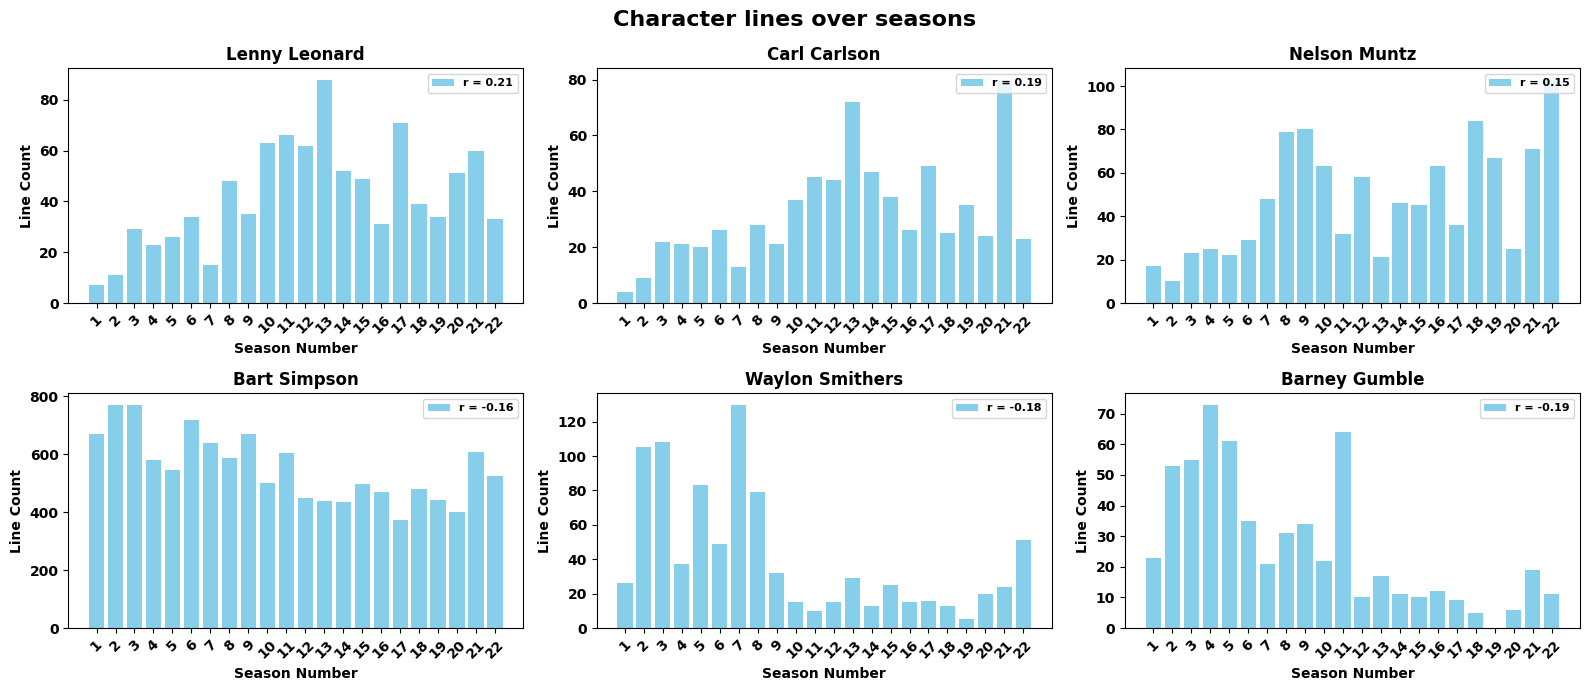

In [25]:
def count_lines_by_season(script_lines_df, character_names):
    num_plots = len(character_names)
    num_rows = 2
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 7))

    for i, character_name in enumerate(character_names):
      
        character_id = character_df.loc[character_df['normalized_name'] == character_name, 'id'].iloc[0]

        filtered_df = script_lines_df[script_lines_df['character_id'] == character_id]

        count_by_season = filtered_df.groupby('season').size().reset_index(name='line_count')

        row = i // num_cols
        col = i % num_cols

     
        axes[row, col].bar(count_by_season['season'], count_by_season['line_count'], color='skyblue')
        axes[row, col].set_title(f"{character_name.title()}", fontsize=12)
        axes[row, col].set_xlabel('Season Number', fontsize=10)
        axes[row, col].set_ylabel('Line Count', fontsize=10)
        axes[row, col].tick_params(axis='x', rotation=45)
        


        x_ticks = np.arange(1, 23, 1)
        axes[row, col].set_xticks(x_ticks)
        
        if character_name in top_character_correlation_episodes_df['variables'].values:
            r_value = top_character_correlation_episodes_df.loc[top_character_correlation_episodes_df['variables'] == character_name, 'r'].values[0]
            axes[row, col].legend([f"r = {r_value:.2f}"], loc='upper right', fontsize=8, facecolor='white')

    fig.suptitle('Character lines over seasons', fontsize=16)    
    fig.tight_layout()
    plt.show()


character_names = ['lenny leonard', 'carl carlson', 'nelson muntz', 'bart simpson', 'waylon smithers', 'barney gumble']

count_lines_by_season(script_lines_df, character_names)


## Locations
#### ok lets start whith location and lets see if we find something

In [26]:
# First we are going to check how much apparear every location from the tv show
location_id_counts = script_lines_df['location_id'].value_counts()

total_rows = len(script_lines_df)

location_id_percentage_df = (location_id_counts / total_rows) * 100

location_id_percentage_df = pd.DataFrame({'location_id': location_id_percentage_df.index, 'appearance_percentage': location_id_percentage_df.values})

location_id_percentage_df = pd.merge(location_id_percentage_df, location_df[['id', 'name', 'normalized_name']], left_on='location_id', right_on='id', how='left')

location_id_percentage_df.drop(columns=['id'], inplace=True)

location_id_percentage_df.sort_values(by='appearance_percentage', ascending=False, inplace=True)

location_id_percentage_df.head(20)

location_id  appearance_percentage                             name  \
0           5.0              22.439646                     Simpson Home   
1           3.0               4.227313    Springfield Elementary School   
2          15.0               2.800375                     Moe's Tavern   
3          10.0               2.052827  Springfield Nuclear Power Plant   
4         136.0               0.960820                      Kwik-E-Mart   
5          25.0               0.935168              Simpson Living Room   
6         131.0               0.835495      First Church of Springfield   
7         151.0               0.827434                      Simpson Car   
8         270.0               0.811310               Springfield Street   
9           1.0               0.781994                           Street   
10        188.0               0.773200                    Flanders Home   
11        216.0               0.762939                      Springfield   
12         48.0               0.740220            Springfield Town Hall   
13         79.0               0.672794    Springfield Retirement Castle   
14         53.0               0.611964                      Burns Manor   
15        194.0               0.563593                        Courtroom   
16        140.0               0.543805                  Simpson Kitchen   
17          8.0               0.487372                 Springfield Mall   
18         84.0               0.457324                 Bart's Treehouse   
19        192.0               0.419213       Springfield Police Station   

                    normalized_name  
0                      simpson home  
1     springfield elementary school  
2                        moe tavern  
3   springfield nuclear power plant  
4                       kwik-e-mart  
5               simpson living room  
6       first church of springfield  
7                       simpson car  
8                springfield street  
9                            street  
10                    flanders home  
11                      springfield  
12            springfield town hall  
13    springfield retirement castle  
14                      burns manor  
15                        courtroom  
16                  simpson kitchen  
17                 springfield mall  
18                   bart treehouse  
19       springfield police station

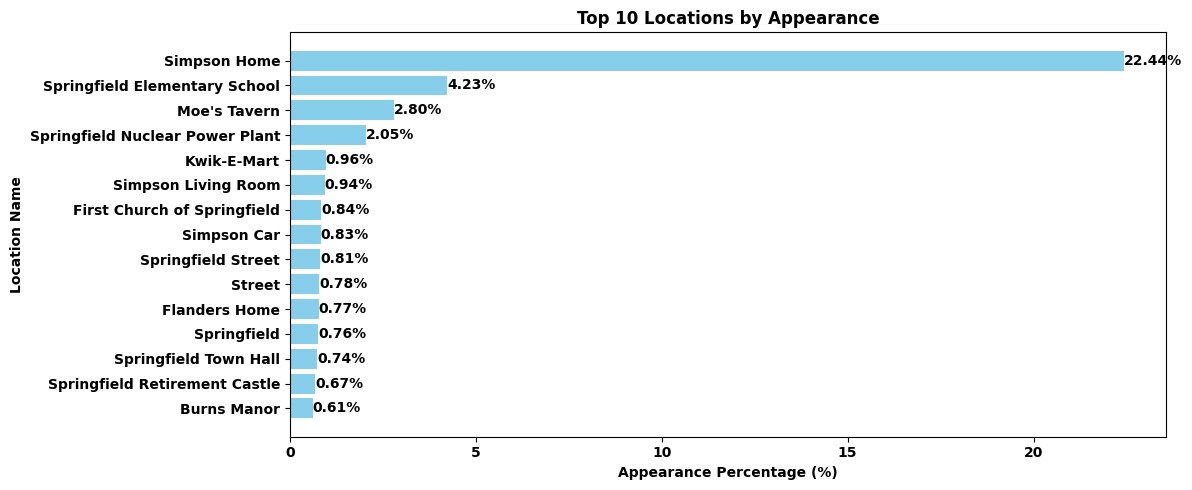

In [27]:
# now we will plot the top 10 location whith there % of appearance

top_locations = location_id_percentage_df.head(15)


plt.figure(figsize=(12, 5))
bars = plt.barh(top_locations['name'], top_locations['appearance_percentage'], color='skyblue')


for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', 
             va='center', ha='left', color='black', fontsize=10)

plt.xlabel('Appearance Percentage (%)')
plt.ylabel('Location Name')
plt.title('Top 10 Locations by Appearance')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


In [28]:
# we are going to work only with the top 30
top30_location_percentage_df = location_id_percentage_df.head(30)
top30_location_percentage_df.head(2)

location_id  appearance_percentage                           name  \
0          5.0              22.439646                   Simpson Home   
1          3.0               4.227313  Springfield Elementary School   

                 normalized_name  
0                   simpson home  
1  springfield elementary school

In [141]:
location_30_proportion_df = calculate_item_percentage_per_episode('location_id', location_df, top30_location_percentage_df,script_lines_df, episode_df)

<Figure size 1600x1200 with 0 Axes>

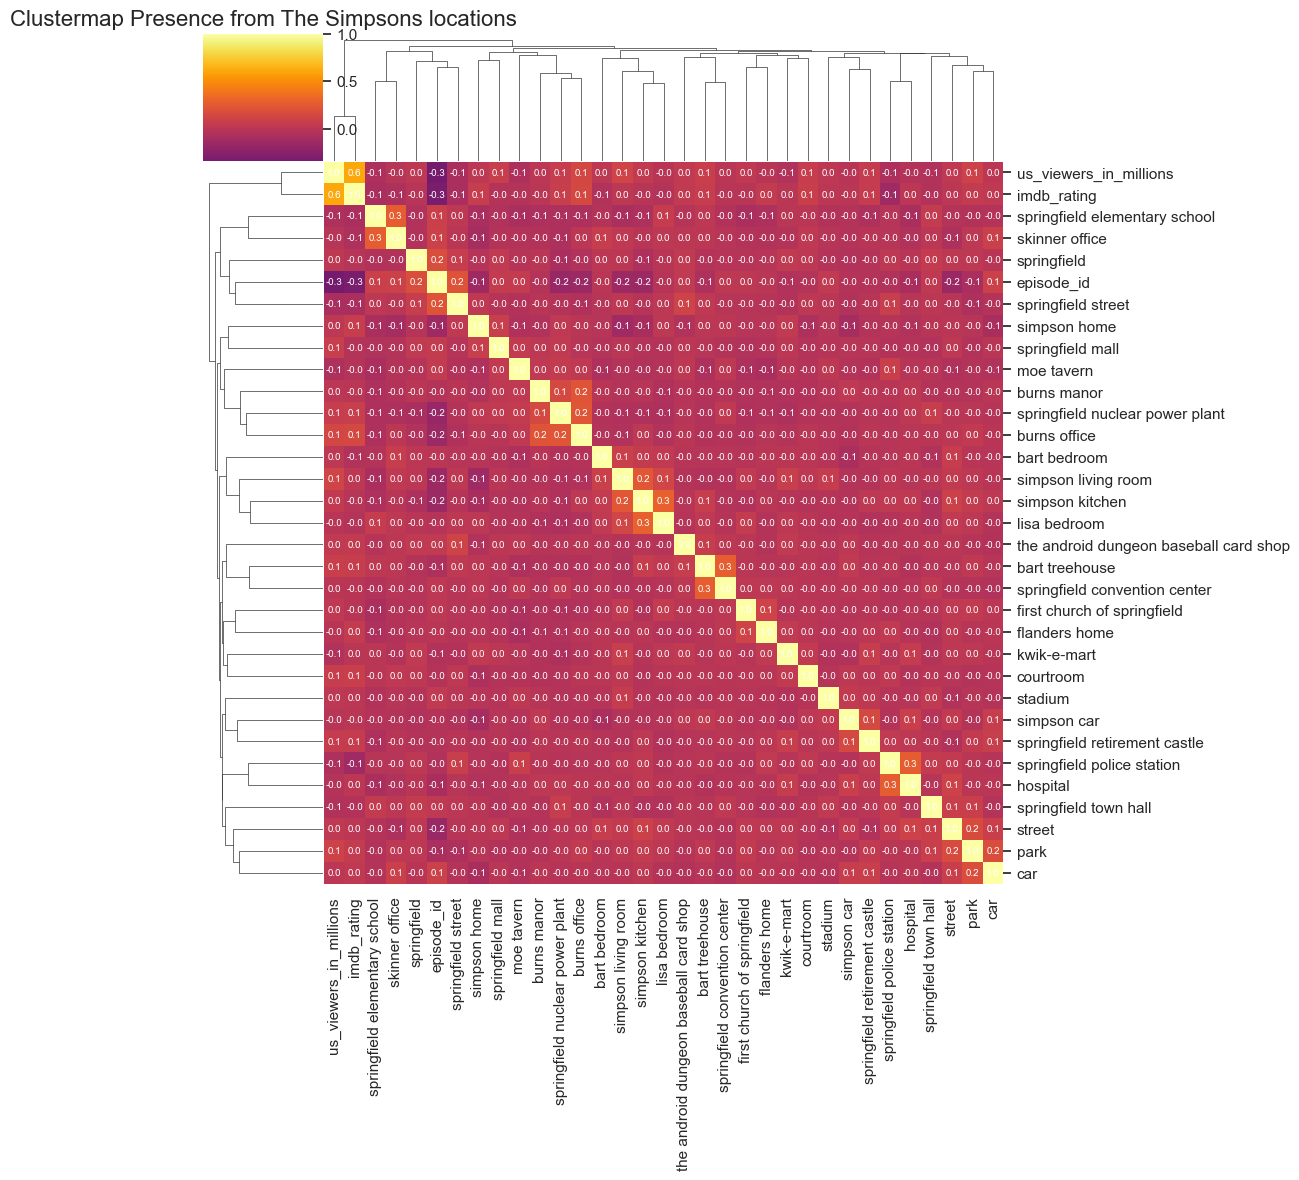

In [139]:
# Plot heatmap
plt.figure(figsize=(16, 12))

location_cluster = sns.clustermap(location_30_proportion_df,
                    annot=True,
                    fmt=".1f",
                    annot_kws={"fontsize": 7, "color": "white", "ha": "center", "va": "center"},                 
                    cmap="inferno",
                    cbar=True,
                    center=0,
                    dendrogram_ratio=(0.15,0.15),
                    row_cluster=True,
                    col_cluster=True,
                    xticklabels=1)

location_cluster.ax_heatmap.figure.axes[-1].set_position([-0.15, 0.5, 0.05, 0.5]) 

plt.title('Clustermap Presence from The Simpsons locations', fontsize=16)
plt.xlabel('', fontsize=8)
plt.ylabel('', fontsize=8)
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1)
plt.show()

In [31]:
percentages_of_locations = calculate_variable_percentages(script_lines_df, location_df, episode_df, location_df)

top_percentages_of_locations = percentages_of_locations.loc[:, (percentages_of_locations != 0).sum() >= 20]
top_percentages_of_locations.head(2)

episode_id    street       car  springfield elementary school  auditorium  \
0           1  0.126471  0.344118                       0.008824    0.002941   
1           2  0.083942  0.208029                       0.065693    0.000000   

   simpson home   kitchen  springfield mall  the happy sailor tattoo parlor  \
0      0.008824  0.002941           0.15000                        0.061765   
1      0.000000  0.000000           0.29927                        0.036496   

   springfield nuclear power plant  ...  martin house  cemetery gate  \
0                         0.047059  ...           0.0            0.0   
1                         0.000000  ...           0.0            0.0   

   rural roadside  springfield dog park  playing field  \
0             0.0                   0.0            0.0   
1             0.0                   0.0            0.0   

   tire store waiting room  branson  large marble-floored room  \
0                      0.0      0.0                        0.0   
1                      0.0      0.0                        0.0   

   us_viewers_in_millions  imdb_rating  
0                    30.4          8.3  
1                    33.6          8.2  

[2 rows x 99 columns]

In [32]:
# now we call the pearson funtion
location_correlation_imdb_df = calculate_pearson_correlations(top_percentages_of_locations,'imdb_rating')
location_correlation_episodes_df = calculate_pearson_correlations(top_percentages_of_locations,'episode_id')


In [33]:
#Correlation of locations agains imdb rating.

location_correlation_imdb_df = location_correlation_imdb_df[location_correlation_imdb_df['p_value_significant'] == True]
location_correlation_imdb_df.sort_values(by='r', ascending=False)

variables  times_appear         r       r^2       p_value  \
97   us_viewers_in_millions           477  0.585896  0.343274  1.403950e-45   
2                       car           480  0.097886  0.009582  3.202249e-02   
16         springfield down            32  0.094273  0.008887  3.895818e-02   
24        a bumpy dirt road           119  0.087866  0.007720  5.438648e-02   
14                 workshop           166  0.084446  0.007131  6.451448e-02   
84    springfield boardwalk            53 -0.076259  0.005815  9.515077e-02   
22              coffee room           126 -0.080380  0.006461  7.852815e-02   
31         noiseland arcade           236 -0.085623  0.007331  6.086820e-02   
53               hotel room           121 -0.089234  0.007963  5.072321e-02   
13           santa workshop           318 -0.112238  0.012597  1.387892e-02   
94  tire store waiting room            33 -0.115295  0.013293  1.147678e-02   
71             meeting room            74 -0.124978  0.015619  6.111308e-03   
86          drainage tunnel            71 -0.151182  0.022856  8.914711e-04   
0                episode_id           480 -0.319375  0.102000  7.639991e-13   

    p_value_significant  
97                 True  
2                  True  
16                 True  
24                 True  
14                 True  
84                 True  
22                 True  
31                 True  
53                 True  
13                 True  
94                 True  
71                 True  
86                 True  
0                  True

#### correlation of location whith imdb. nothing to see here..

In [34]:
#Correlation of locations agains .

top_location_correlation_episodes_df = location_correlation_episodes_df.loc[(location_correlation_episodes_df['times_appear'] > 200) & (location_correlation_episodes_df['p_value_significant'] == True)]
top_location_correlation_episodes_df.sort_values(by='r', ascending=False).head(30)

variables  times_appear         r       r^2  \
43                barney apartment           267  0.206010  0.042440   
44            ye olde off-ramp inn           233  0.190619  0.036336   
30                noiseland arcade           238  0.146202  0.021375   
12                  santa workshop           320  0.101628  0.010328   
7   the happy sailor tattoo parlor           481  0.082038  0.006730   
16             simpson living room           267  0.082011  0.006726   
1                              car           483 -0.092802  0.008612   
11                      moe tavern           208 -0.117277  0.013754   
6                 springfield mall           482 -0.159978  0.025593   
97                     imdb_rating           480 -0.245830  0.060432   
96          us_viewers_in_millions           477 -0.325932  0.106231   

         p_value  p_value_significant  
43  4.998173e-06                 True  
44  2.474070e-05                 True  
30  1.272404e-03                 True  
12  2.551580e-02                 True  
7   7.164986e-02                 True  
16  7.174370e-02                 True  
1   4.148486e-02                 True  
11  9.890014e-03                 True  
6   4.163099e-04                 True  
97  4.427747e-08                 True  
96  2.041182e-13                 True

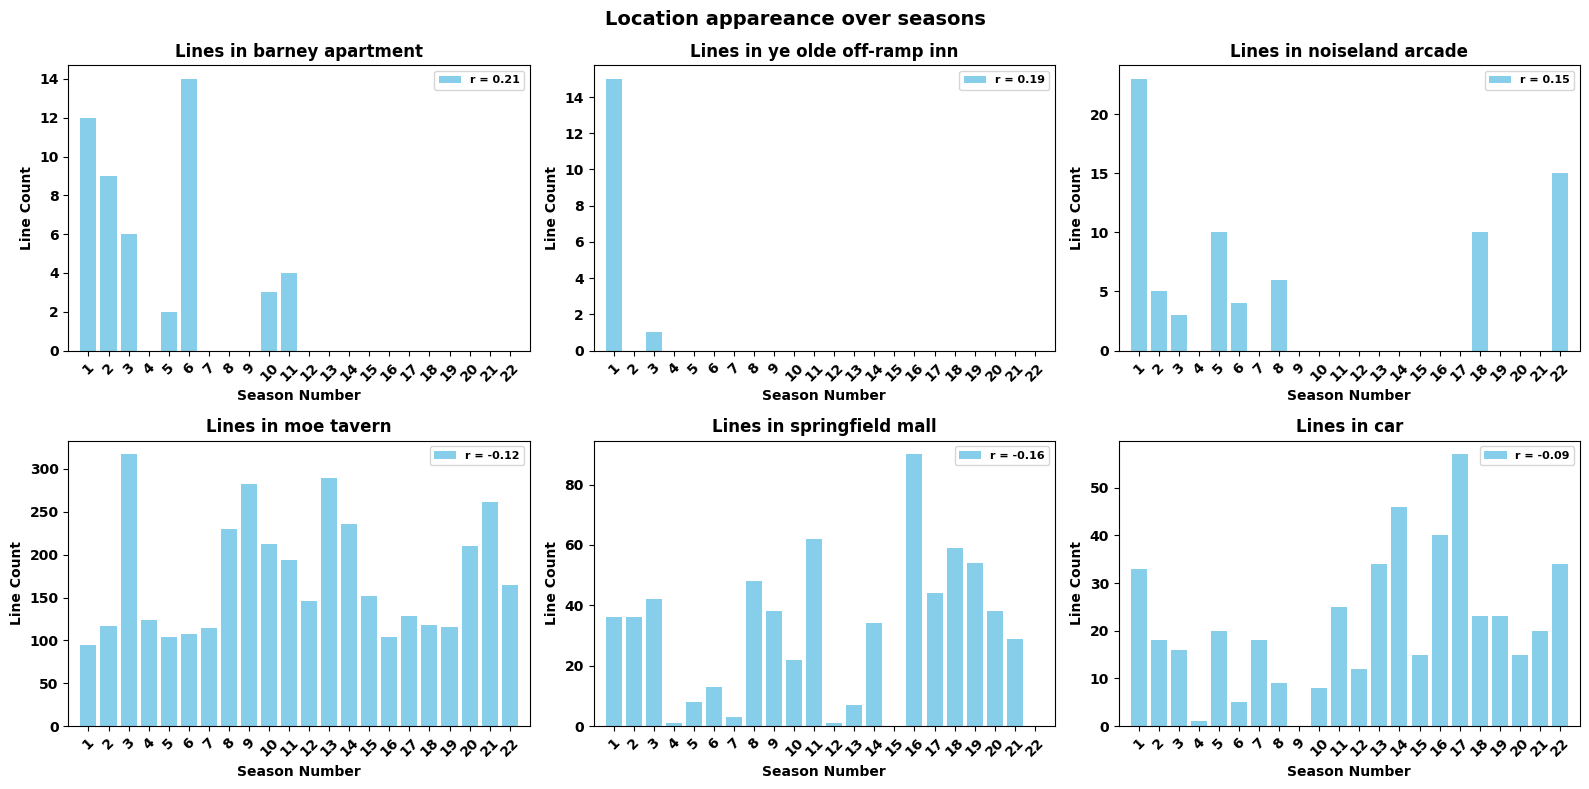

In [35]:
def count_lines_by_season_for_location(script_lines_df, location_names):
    num_plots = len(location_names)
    num_rows = 2
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))  

    for i, location_name in enumerate(location_names):

        location_id = location_df.loc[location_df['normalized_name'] == location_name, 'id'].iloc[0]

        filtered_df = script_lines_df[script_lines_df['location_id'] == location_id]

        count_by_season = filtered_df.groupby('season').size().reset_index(name='line_count')

        
        row = i // num_cols
        col = i % num_cols

        axes[row, col].bar(count_by_season['season'], count_by_season['line_count'], color='skyblue')
        axes[row, col].set_title(f"Lines in {location_name}", fontsize=12)
        axes[row, col].set_xlabel('Season Number', fontsize=10)
        axes[row, col].set_ylabel('Line Count', fontsize=10)
        axes[row, col].tick_params(axis='x', rotation=45)

        axes[row, col].set_xlim(0, 23)

        if location_name in top_location_correlation_episodes_df['variables'].values:
            r_value = top_location_correlation_episodes_df.loc[top_location_correlation_episodes_df['variables'] == location_name, 'r'].values[0]
            axes[row, col].legend([f"r = {r_value:.2f}"], loc='upper right', fontsize=8, facecolor='white')

        x_ticks = np.arange(1, 23, 1)
        
        
        
        axes[row, col].set_xticks(x_ticks)
    fig.suptitle('Location appareance over seasons', fontsize=14)
    fig.tight_layout()
    plt.show() 


location_names = ['barney apartment', 'ye olde off-ramp inn', 'noiseland arcade', 'moe tavern', 'springfield mall', 'car']

count_lines_by_season_for_location(script_lines_df, location_names)



#### we can get to the conclution that the location dosent have something interesting in what it is correlation

## Emotions
#### Now we are going to see the emotions, there relation with the imdb and during episodes. after that will see it for every character looking for something intereting

In [36]:
#Now we get a dataframe with the mean emotion valueas per season per character

mean_emotional_lines_per_season  = pd.merge(emotional_lines_df, script_lines_df[['emotional_id', 'season', 'character_id']], on='emotional_id', how='inner')

mean_emotional_lines_per_season = mean_emotional_lines_per_season.drop('emotional_id', axis=1)

mean_emotional_lines_per_season = mean_emotional_lines_per_season.groupby(['season', 'character_id'], as_index=False).mean()

mean_emotional_lines_per_season  = pd.merge(mean_emotional_lines_per_season, character_df[['id', 'normalized_name']], left_on='character_id', right_on='id', how='inner')

mean_emotional_lines_per_season = mean_emotional_lines_per_season.drop('id', axis=1)

mean_emotional_lines_per_season = pd.melt(mean_emotional_lines_per_season, id_vars=['season', 'character_id', 'normalized_name'], var_name='emotion', value_name='value')

mean_emotional_lines_per_season = mean_emotional_lines_per_season.sort_values(by='character_id')

mean_emotional_lines_per_season

season  character_id normalized_name      emotion     value
0            1           1.0   marge simpson      neutral  0.551503
43639       21           1.0   marge simpson     approval  0.058442
198111       8           1.0   marge simpson         fear  0.010685
43287       20           1.0   marge simpson     approval  0.061086
198490       9           1.0   marge simpson         fear  0.008287
...        ...           ...             ...          ...       ...
204193      22        5876.0       moes face         fear  0.002754
213071      22        5876.0       moes face    gratitude  0.000511
221949      22        5876.0       moes face  nervousness  0.000985
115413      22        5876.0       moes face     optimism  0.008802
248583      22        5876.0       moes face        pride  0.002293

[248584 rows x 5 columns]

In [37]:
#save it!
mean_emotional_lines_per_season.to_csv(r'cvs_files\emotion_season_character.csv', index=False)

In [38]:
#Now we get a dataframe with the mean emotion valueas per episode per character

mean_emotional_lines_per_episode  = pd.merge(emotional_lines_df, script_lines_df[['emotional_id', 'episode_id', 'character_id']], on='emotional_id', how='inner')

mean_emotional_lines_per_episode = mean_emotional_lines_per_episode.drop('emotional_id', axis=1)

mean_emotional_lines_per_episode = mean_emotional_lines_per_episode.groupby(['episode_id', 'character_id'], as_index=False).mean()

mean_emotional_lines_per_episode  = pd.merge(mean_emotional_lines_per_episode, character_df[['id', 'normalized_name']], left_on='character_id', right_on='id', how='inner')

mean_emotional_lines_per_episode = mean_emotional_lines_per_episode.drop('id', axis=1)

mean_emotional_lines_per_episode = pd.melt(mean_emotional_lines_per_episode, id_vars=['episode_id', 'character_id', 'normalized_name'], var_name='emotion', value_name='value')

mean_emotional_lines_per_episode.sort_values(by='character_id')


episode_id  character_id normalized_name      emotion     value
0                1           1.0   marge simpson      neutral  0.575823
226617          96           1.0   marge simpson    curiosity  0.030303
226570          95           1.0   marge simpson    curiosity  0.008038
226541          94           1.0   marge simpson    curiosity  0.040168
226499          93           1.0   marge simpson    curiosity  0.049424
...            ...           ...             ...          ...       ...
395093         486        5876.0       moes face         fear  0.002754
412271         486        5876.0       moes face    gratitude  0.000511
429449         486        5876.0       moes face  nervousness  0.000985
223313         486        5876.0       moes face     optimism  0.008802
480983         486        5876.0       moes face        pride  0.002293

[480984 rows x 5 columns]

In [39]:
#And the proportion of the emotions por the whole show

mean_of_emotions = mean_emotional_lines_per_episode.drop(['character_id','episode_id','normalized_name'], axis=1)

mean_of_emotions = mean_of_emotions.groupby('emotion', as_index=False).mean()

mean_of_emotions = mean_of_emotions.sort_values(by= 'value', ascending= False)

mean_of_emotions

emotion     value
20         neutral  0.608867
4         approval  0.057119
0       admiration  0.043262
3        annoyance  0.036624
10     disapproval  0.032555
7        curiosity  0.029229
26         sadness  0.024299
17             joy  0.021086
2            anger  0.019906
6        confusion  0.019489
15       gratitude  0.018670
9   disappointment  0.018251
5           caring  0.018167
13      excitement  0.018137
18            love  0.017273
23     realization  0.016857
1        amusement  0.012169
8           desire  0.011915
27        surprise  0.011790
21        optimism  0.011636
25         remorse  0.009140
14            fear  0.009032
11         disgust  0.008839
12   embarrassment  0.003354
19     nervousness  0.002229
24          relief  0.002179
22           pride  0.001753
16           grief  0.001256

In [40]:
# we are going to take the neutral value. it means nothing for what we are looking for

mean_of_emotions = mean_of_emotions[mean_of_emotions['emotion'] != 'neutral']

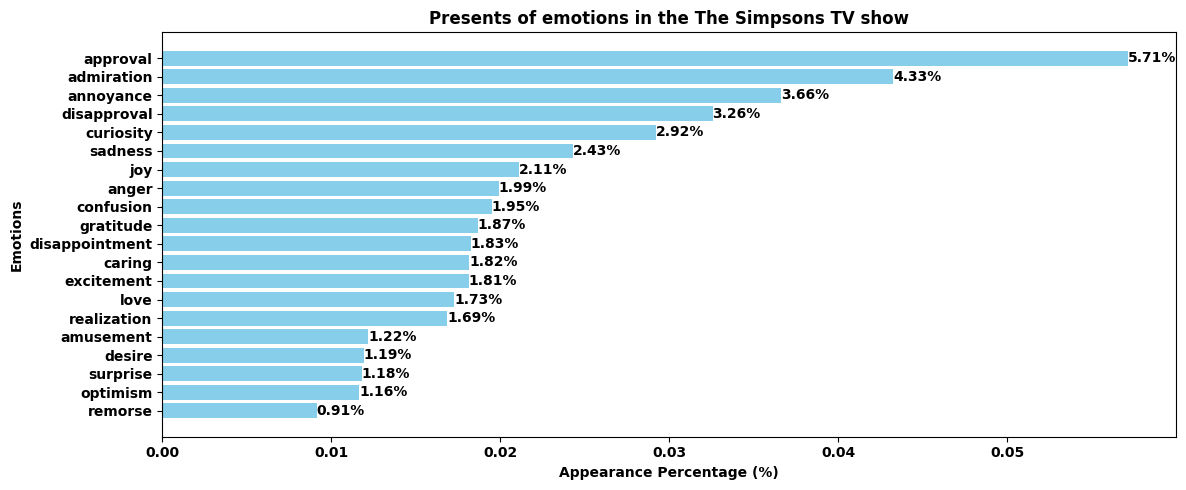

In [41]:
#now we plot the emotions presence from the hole tv show
    
top_mean_of_emotions = mean_of_emotions.head(20)

plt.figure(figsize=(12, 5))
bars = plt.barh(top_mean_of_emotions['emotion'], top_mean_of_emotions['value'], color='skyblue')


for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{(bar.get_width())*100:.2f}%', 
             va='center', ha='left', color='black', fontsize=10)

plt.xlabel('Appearance Percentage (%)')
plt.ylabel('Emotions')
plt.title('Presents of emotions in the The Simpsons TV show')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


#### Now we are going to start looking for more generic correlations: emotions agains imdb and episodes and look for something significant!

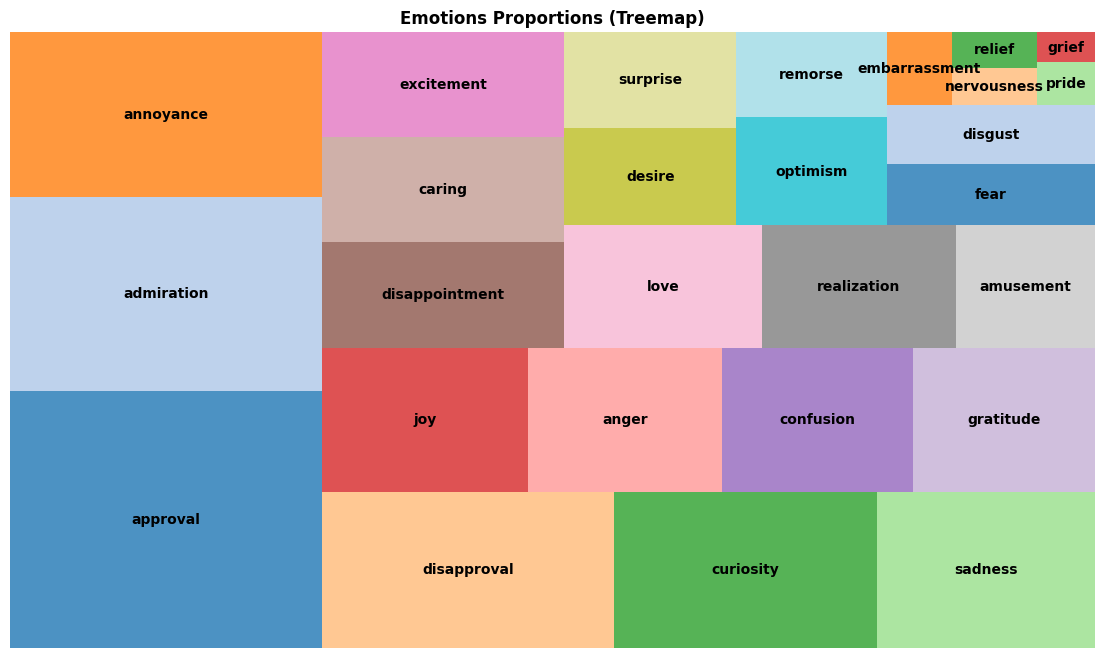

In [42]:

def plot_emotion_treemap(dataframe):
  
    dataframe_sorted = dataframe.sort_values(by='value', ascending=False)
    
    # Calcular el área total para el treemap (sumar todos los valores de 'value')
    total_value = dataframe_sorted['value'].sum()
    
    # Calcular el tamaño relativo de cada cuadrado en el treemap
    sizes = (dataframe_sorted['value'] / total_value) * 100
    
    # Crear una lista de colores para cada categoría 'emotion'
    colors = plt.cm.tab20.colors[:len(dataframe_sorted)]
    
    # Crear el treemap usando squarify
    plt.figure(figsize=(14, 8))
    squarify.plot(sizes=sizes, label=dataframe_sorted['emotion'], color=colors, alpha=0.8, pad=False)

    # Añadir etiquetas al treemap
    plt.title('Emotions Proportions (Treemap)')
    plt.axis('off')  # Desactivar los ejes
    plt.show()


plot_emotion_treemap(mean_of_emotions)


In [43]:
#lets work only whith the main characters that appear in at least 50 episodes

merged_df = pd.merge(script_lines_df, character_df[['id', 'normalized_name']], left_on='character_id', right_on='id', how='left')


unique_episodes_per_name = merged_df.groupby('normalized_name')['episode_id'].nunique().reset_index()

unique_episodes_per_name.columns = ['normalized_name', 'unique_episode_count']

filtered_names = unique_episodes_per_name[unique_episodes_per_name['unique_episode_count'] > 50]

filtered_names.sort_values(by='unique_episode_count')

list_main_characters = filtered_names['normalized_name'].to_list()

values_to_remove = ['crowd', 'kids', 'man', 'woman','nurse', 'audience']
for value in values_to_remove:
    if value in list_main_characters:
        list_main_characters.remove(value)
        
len(list_main_characters)

47

In [44]:
mean_emotional_lines_per_episode_main_characters = mean_emotional_lines_per_episode[mean_emotional_lines_per_episode['normalized_name'].isin(list_main_characters) ]


mean_emotional_lines_per_episode_main_characters = mean_emotional_lines_per_episode[mean_emotional_lines_per_episode['normalized_name'] == 'marge simpson']
mean_emotional_lines_per_episode_main_characters = mean_emotional_lines_per_episode_main_characters[mean_emotional_lines_per_episode_main_characters['emotion'] == 'pride']

mean_emotional_lines_per_episode_main_characters


episode_id  character_id normalized_name emotion     value
463806           1           1.0   marge simpson   pride  0.001305
463843           2           1.0   marge simpson   pride  0.001170
463864           3           1.0   marge simpson   pride  0.035122
463897           4           1.0   marge simpson   pride  0.001927
463930           5           1.0   marge simpson   pride  0.000974
...            ...           ...             ...     ...       ...
480829         482           1.0   marge simpson   pride  0.001066
480856         483           1.0   marge simpson   pride  0.000959
480887         484           1.0   marge simpson   pride  0.001364
480918         485           1.0   marge simpson   pride  0.000718
480954         486           1.0   marge simpson   pride  0.001456

[482 rows x 5 columns]

In [45]:
emotion_episodes_proportions = pd.merge(emotional_lines_df, script_lines_df[['emotional_id', 'episode_id']], on='emotional_id', how='inner')
emotion_episodes_proportions.drop(columns=['emotional_id'], inplace=True)
emotion_episodes_proportions.head(3)


neutral  disapproval  annoyance  disappointment  approval  realization  \
0  0.013570     0.014384   0.006634        0.035880  0.067097     0.016827   
1  0.594302     0.003356   0.016335        0.007102  0.012534     0.011262   
2  0.085622     0.559732   0.152330        0.034718  0.015766     0.008330   

      anger    desire   sadness  excitement  ...    relief  embarrassment  \
0  0.005142  0.004853  0.243649    0.003562  ...  0.004990       0.008168   
1  0.004460  0.001880  0.003631    0.099866  ...  0.001709       0.005707   
2  0.051575  0.001721  0.009196    0.001047  ...  0.000573       0.009784   

       love      fear  gratitude  nervousness     grief   remorse     pride  \
0  0.101742  0.002450   0.023776     0.002164  0.012175  0.594076  0.005640   
1  0.005331  0.007303   0.001092     0.001702  0.001407  0.000461  0.002112   
2  0.003832  0.004522   0.001437     0.000811  0.000584  0.001542  0.000366   

   episode_id  
0         298  
1         298  
2         298  

[3 rows x 29 columns]

In [46]:
avg_emotions_episode_df = emotion_episodes_proportions.groupby('episode_id').mean().reset_index()

avg_emotions_episode_df =pd.merge(avg_emotions_episode_df, episode_df[['id', 'imdb_rating']], left_on='episode_id', right_on='id', how='inner')

avg_emotions_episode_df.drop(columns=['id','neutral'], inplace=True)

avg_emotions_episode_df.head(3)


episode_id  disapproval  annoyance  disappointment  approval  realization  \
0           1     0.017667   0.023793        0.019918  0.053133     0.015329   
1           2     0.045961   0.040107        0.016304  0.062005     0.014268   
2           3     0.030989   0.038015        0.020255  0.080414     0.019130   

      anger    desire   sadness  excitement  ...    relief  embarrassment  \
0  0.011630  0.017342  0.019971    0.028221  ...  0.002288       0.002056   
1  0.019763  0.008296  0.011612    0.021643  ...  0.001576       0.002064   
2  0.012963  0.016079  0.030455    0.016904  ...  0.002066       0.002636   

       love      fear  gratitude  nervousness     grief   remorse     pride  \
0  0.021443  0.007672   0.020667     0.002341  0.001168  0.008632  0.002419   
1  0.007299  0.002863   0.011830     0.001210  0.000709  0.010413  0.000913   
2  0.014166  0.006080   0.007165     0.001723  0.001439  0.011621  0.005301   

   imdb_rating  
0          8.2  
1          7.8  
2          7.5  

[3 rows x 29 columns]

In [47]:
# Now we look for the correlations between the features that are interesting

columns_to_compare = avg_emotions_episode_df.columns.difference(['episode_id', 'imdb_rating'])


emotions_correlation_df = pd.DataFrame(index=['episode_id', 'imdb_rating'], columns=columns_to_compare)


for column in columns_to_compare:
    for index in emotions_correlation_df.index:
        emotions_correlation_df.at[index, column] = avg_emotions_episode_df[column].corr(avg_emotions_episode_df[index])

emotions_correlation_df = emotions_correlation_df.apply(pd.to_numeric)

emotions_correlation_df_trasnpose = emotions_correlation_df.T
emotions_correlation_df_trasnpose

episode_id  imdb_rating
admiration        0.067712    -0.111256
amusement        -0.187227     0.163020
anger             0.000204     0.031400
annoyance         0.026430     0.054851
approval         -0.109762     0.057313
caring           -0.020533     0.021716
confusion         0.038676     0.005743
curiosity         0.061804    -0.069709
desire            0.030571    -0.055440
disappointment    0.076179    -0.063251
disapproval      -0.151562     0.128412
disgust           0.025757    -0.044178
embarrassment    -0.004732     0.023879
excitement       -0.090796     0.016564
fear             -0.001583     0.032759
gratitude        -0.113350     0.062047
grief             0.059087    -0.107387
joy               0.073067    -0.080247
love              0.149096    -0.213613
nervousness      -0.020737     0.032999
optimism         -0.069872     0.076124
pride            -0.032332     0.072758
realization       0.158297    -0.091521
relief            0.082669    -0.030840
remorse          -0.118102     0.082735
sadness           0.060267    -0.128858
surprise         -0.057403     0.072952

In [48]:
sns.__version__

'0.13.0'

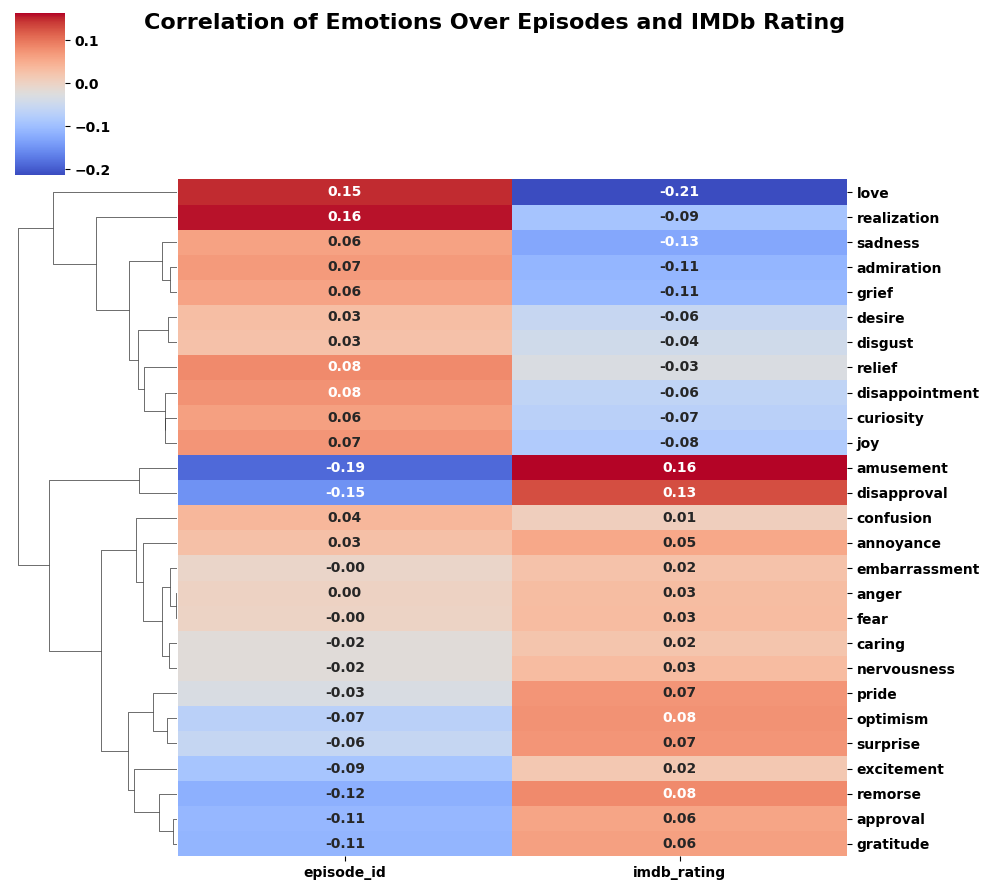

In [49]:
# Lets see the cluster cluster map
cluster = sns.clustermap(emotions_correlation_df_trasnpose, cmap='coolwarm', annot=True,  col_cluster=False, figsize=(10, 9), fmt='.2f')

cluster.fig.suptitle('Correlation of Emotions Over Episodes and IMDb Rating', fontsize=16)

plt.show()


####

C:\Users\ltf-g\AppData\Local\Temp\ipykernel_10184\3159864669.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [plt.text(episode_id_values[i], imdb_rating_values[i], labels[i], fontsize=12) for i in range(len(labels))]


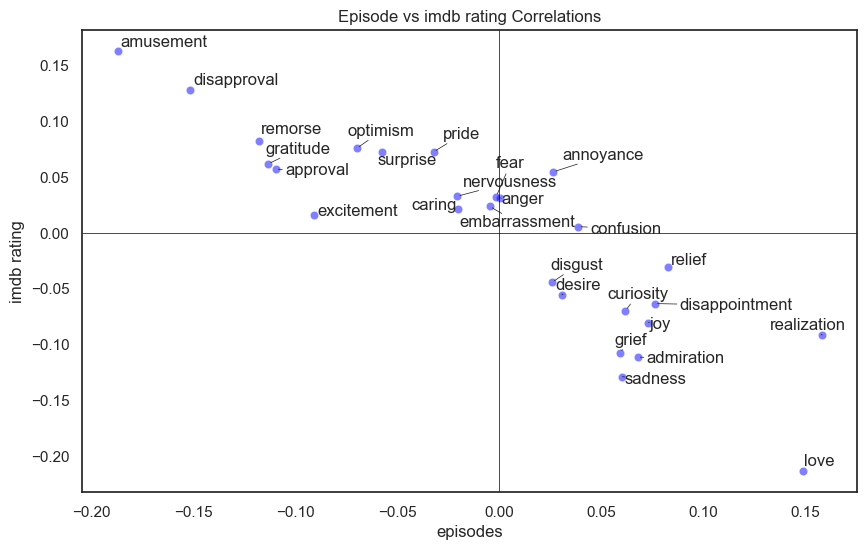

In [50]:
# Now in a scatter plot between episodes and imbd

transpose_emotions_correlation_df = emotions_correlation_df.transpose()

sns.set(style="white") 
plt.figure(figsize=(10, 6))

episode_id_values = transpose_emotions_correlation_df['episode_id']
imdb_rating_values = transpose_emotions_correlation_df['imdb_rating']

ax = sns.scatterplot(x=episode_id_values, y=imdb_rating_values, color='blue', alpha=0.5)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.title('Episode vs imdb rating Correlations')
plt.xlabel('episodes')
plt.ylabel('imdb rating')

labels = [txt for txt in transpose_emotions_correlation_df.index]
texts = [plt.text(episode_id_values[i], imdb_rating_values[i], labels[i], fontsize=12) for i in range(len(labels))]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5)) 

plt.show()

#### For those who are not familiar with the concept of correlations, it indicates how related the variables are. In this case, it compares the emotions or feelings to the IMDb rating on the vertical axis against episodes on the horizontal axis. The higher the number of the emotion in the IMDb rating, the stronger the positive correlation it has with it. For instance, the best episodes tend to have more sentiments like amusement, surprise, and disapproval, while the worst ones exhibit more love, sadness, and curiosity. Concerning the horizontal axis representing episodes correlation, the higher the episode number (newer episodes), the more sentiments of realization, curiosity, and confusion tend to be present.
#### Of course, emotions that are more expressed in the newer episodes also tend to have lower IMDb ratings (crappy episodes), because the newer the episode, the lower the rating (r = -0.19).

In [51]:

def create_character_emotional_dataframe(list_characters):
    # Get unique emotions from emotional_lines_df columns
    emotions = emotional_lines_df.drop('emotional_id', axis=1).columns
    emotions = emotions.append(pd.Index(['character_id', 'normalized_name']))
    
    # Initialize a list to accumulate data
    data = []
    
    for character_name in list_characters:
        # Find character info by normalized_name
        character_info = character_df[character_df['normalized_name'] == character_name]
        if character_info.empty:
            raise ValueError(f"No information found for character '{character_name}' in character_df.")
        
        character_id = character_info['id'].values[0]
        
        # Filter script lines to get emotional_ids associated with the character
        character_lines = script_lines_df[script_lines_df['character_id'] == character_id]
        emotional_ids = character_lines['emotional_id'].unique()
        
        # Filter emotional lines to get relevant emotions based on emotional_ids
        character_emotions = emotional_lines_df[emotional_lines_df['emotional_id'].isin(emotional_ids)]
        
        # Merge with script_lines_df to include episode_id
        character_emotions = pd.merge(character_emotions, script_lines_df[['emotional_id', 'episode_id']], on='emotional_id', how='inner')
        
        # Calculate average emotions grouped by 'episode_id'
        episode_emotions_avg = character_emotions.groupby('episode_id').mean().reset_index()
        
        # Calculate correlations with 'episode_id'
        columns_to_compare = episode_emotions_avg.columns[episode_emotions_avg.columns != 'episode_id']
        correlations = episode_emotions_avg[columns_to_compare].corrwith(episode_emotions_avg['episode_id'])
        
        # Create a dictionary to store correlation values
        correlation_dict = {'character_id': character_id, 'normalized_name': character_name}
        for emotion in emotions:
            if emotion in correlations.index:
                correlation_dict[emotion] = correlations[emotion]
        
        # Append the correlation_dict to the data list
        data.append(correlation_dict)
    
    # Create the DataFrame from the accumulated data
    emotion_df = pd.DataFrame(data)
    
    return emotion_df

# Example usage:
top_50_characters = character_id_percentage_df.head(50)
top_50_characters = top_50_characters['normalized_name']

# Call the function to get the DataFrame of emotions and correlations
corr_emotion_over_episodes = create_character_emotional_dataframe(top_50_characters)

corr_emotion_over_episodes.head(3)

character_id normalized_name   neutral  disapproval  annoyance  \
0             2   homer simpson -0.025155    -0.131107   0.059110   
1             1   marge simpson  0.030041    -0.094554  -0.028811   
2             8    bart simpson  0.035371     0.021545   0.103268   

   disappointment  approval  realization     anger    desire  ...   disgust  \
0        0.032416 -0.126870     0.119556 -0.008723  0.013995  ...  0.066157   
1        0.049124 -0.022503     0.070121  0.039345 -0.018290  ... -0.024181   
2        0.054646 -0.090558     0.105194 -0.034026 -0.006309  ...  0.013066   

     relief  embarrassment      love      fear  gratitude  nervousness  \
0  0.034501       0.006701  0.145131  0.055151  -0.055258     0.028369   
1  0.063196      -0.012130  0.088909 -0.028520   0.018038     0.037435   
2  0.057946      -0.028372 -0.053003 -0.091726  -0.110460    -0.048397   

      grief   remorse     pride  
0  0.061325 -0.009484 -0.056516  
1  0.057276 -0.009452 -0.057114  
2  0.037841 -0.087296 -0.018507  

[3 rows x 30 columns]

In [52]:
#save the dataframe as csv file
corr_emotion_over_episodes.to_csv(r'cvs_files\corr_emotion_over_episodes.csv', index=False)

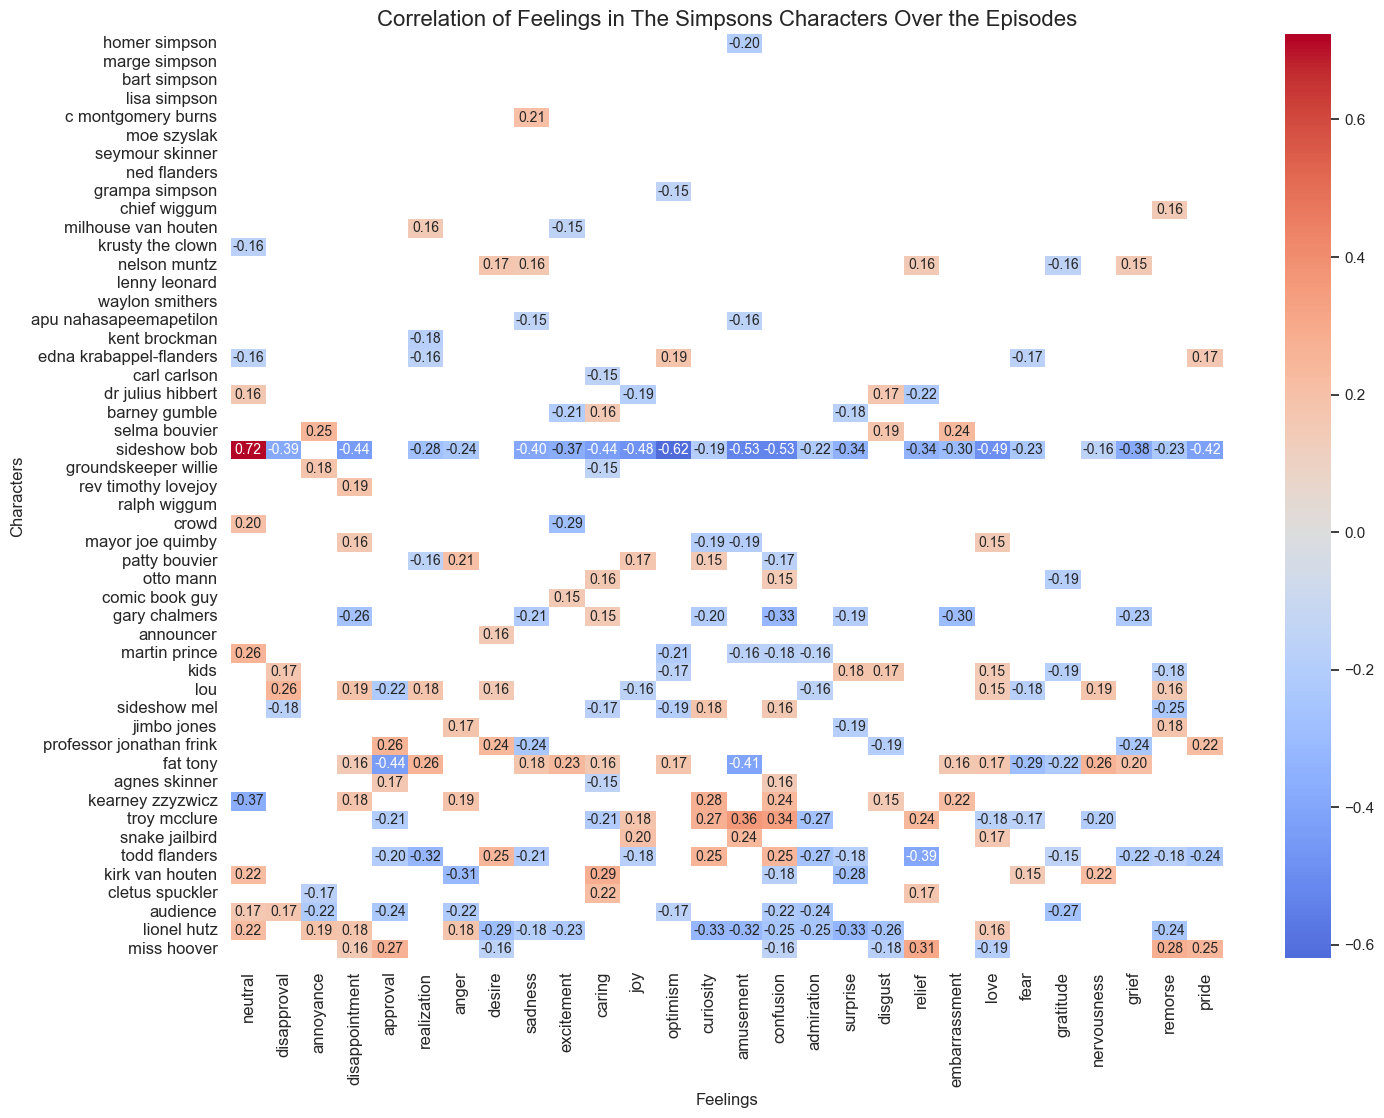

In [166]:
df_subset = corr_emotion_over_episodes.drop(['character_id'], axis=1)

df_subset.set_index('normalized_name', inplace=True)

plt.figure(figsize=(16, 12))

# Filter -0.15 <= values => 0.15 
mask = (df_subset <= 0.15) & (df_subset >= -0.15)

masked_data = df_subset.mask(mask)

sns.heatmap(masked_data, annot=True, annot_kws={"size": 10}, fmt=".2f", cmap='coolwarm', center=0)

plt.title('Correlation of Feelings in The Simpsons Characters Over the Episodes', fontsize=16)
plt.xlabel('Feelings')
plt.ylabel('Characters')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.show()


#### Wow, Sideshow Bob did change over the episodes, which makes sense. He started as a maniacal man trying to kill Bart and evolved into.... well whatever the series' plot needed.

#### In this list, I sum the correlations from every character to see which are the characters that change the most over the episodes.

In [54]:

sum_correlations_emotions = corr_emotion_over_episodes.copy()
sum_correlations_emotions['total_correlation'] = corr_emotion_over_episodes.iloc[:, 2:].abs().sum(axis=1)
sum_correlations_emotions = sum_correlations_emotions[['normalized_name', 'total_correlation']]
sum_correlations_emotions = sum_correlations_emotions.sort_values('total_correlation', ascending=False)
sum_correlations_emotions

normalized_name  total_correlation
22              sideshow bob           9.066554
48               lionel hutz           4.621599
39                  fat tony           4.482458
44             todd flanders           4.251084
42              troy mcclure           3.908292
31             gary chalmers           3.495477
41          kearney zzyzwicz           3.441302
49               miss hoover           3.344395
35                       lou           3.297166
47                  audience           2.950267
45           kirk van houten           2.894672
34                      kids           2.849869
36              sideshow mel           2.848274
33             martin prince           2.636491
38  professor jonathan frink           2.561509
43            snake jailbird           2.551154
12              nelson muntz           2.508877
19         dr julius hibbert           2.395932
17   edna krabappel-flanders           2.355440
28             patty bouvier           2.248356
37               jimbo jones           2.178115
23      groundskeeper willie           2.175487
26                     crowd           2.143859
24       rev timothy lovejoy           2.132157
15    apu nahasapeemapetilon           2.128136
29                 otto mann           2.102791
46           cletus spuckler           2.077903
4         c montgomery burns           2.064019
21             selma bouvier           2.030434
27          mayor joe quimby           2.014477
16             kent brockman           1.841960
40             agnes skinner           1.828862
20             barney gumble           1.800097
8             grampa simpson           1.696643
9               chief wiggum           1.685898
25              ralph wiggum           1.671809
10       milhouse van houten           1.649844
0              homer simpson           1.627365
2               bart simpson           1.603602
30            comic book guy           1.602440
32                 announcer           1.551350
7               ned flanders           1.540980
11          krusty the clown           1.498159
13             lenny leonard           1.450714
6            seymour skinner           1.440550
1              marge simpson           1.371115
18              carl carlson           1.336542
5                moe szyslak           1.325173
14           waylon smithers           1.275164
3               lisa simpson           1.018664

In [55]:
def create_character_emotional_df(character_name):

    character_id = character_df.loc[character_df['normalized_name'] == character_name, 'id'].values[0]
    
    emotional_ids = script_lines_df.loc[script_lines_df['character_id'] == character_id, 'emotional_id'].unique()
    
    character_emotional_lines_df = emotional_lines_df[emotional_lines_df['emotional_id'].isin(emotional_ids)]
    
    character_emotional_lines_df = pd.merge(character_emotional_lines_df, script_lines_df[['emotional_id', 'season']], on='emotional_id', how='inner')
    
    character_emotional_lines_df.drop('emotional_id', axis=1, inplace=True)
    
    character_emotional_lines_df = character_emotional_lines_df.groupby('season').mean().reset_index()
   
    if 'neutral' in character_emotional_lines_df.columns:
        character_emotional_lines_df.drop('neutral', axis=1, inplace=True)
    
    return character_emotional_lines_df

In [56]:
create_character_emotional_df('sideshow bob').head(3)

season  disapproval  annoyance  disappointment  approval  realization  \
0       1     0.007397   0.039003        0.014927  0.067922     0.025099   
1       3     0.048776   0.054048        0.043098  0.041252     0.013558   
2       5     0.135699   0.039674        0.012000  0.054460     0.014652   

      anger    desire   sadness  excitement  ...   disgust    relief  \
0  0.036407  0.008172  0.026754    0.037200  ...  0.005832  0.005891   
1  0.035474  0.030361  0.052535    0.008566  ...  0.013752  0.002131   
2  0.024341  0.003495  0.025835    0.009416  ...  0.007720  0.002538   

   embarrassment      love      fear  gratitude  nervousness     grief  \
0       0.002514  0.104410  0.003598   0.033740     0.002534  0.001780   
1       0.004156  0.046204  0.023146   0.027186     0.003920  0.002481   
2       0.002557  0.003978  0.001765   0.005798     0.001146  0.001094   

    remorse     pride  
0  0.018352  0.013282  
1  0.002427  0.001270  
2  0.016089  0.001747  

[3 rows x 28 columns]

In [57]:
mean_emotional_character = mean_emotional_lines_per_season.drop('season', axis=1)
mean_emotional_character = mean_emotional_character.groupby(['normalized_name', 'emotion'], as_index=False).mean()
mean_emotional_character = mean_emotional_character[mean_emotional_character['normalized_name'].isin(list_main_characters)]

emotions_list = mean_emotional_character[mean_emotional_character['normalized_name'] == 'homer simpson']['emotion'].to_list()
top_interesting_emotions = ['anger','approval','confusion','desire','disapproval','excitement','fear','joy','love','optimism','pride','sadness']

mean_emotional_character

normalized_name      emotion  character_id     value
5320      agnes skinner   admiration         192.0  0.042196
5321      agnes skinner    amusement         192.0  0.007135
5322      agnes skinner        anger         192.0  0.028437
5323      agnes skinner    annoyance         192.0  0.047884
5324      agnes skinner     approval         192.0  0.034646
...                 ...          ...           ...       ...
146603  waylon smithers  realization          14.0  0.018694
146604  waylon smithers       relief          14.0  0.003030
146605  waylon smithers      remorse          14.0  0.009138
146606  waylon smithers      sadness          14.0  0.024678
146607  waylon smithers     surprise          14.0  0.006256

[1316 rows x 4 columns]

In [164]:
heatmap_mean_emotional_character = mean_emotional_character.drop('character_id', axis=1)
heatmap_mean_emotional_character

heatmap_mean_emotional_character = heatmap_mean_emotional_character.pivot_table(index='normalized_name', columns='emotion', values='value', fill_value=0)

heatmap_mean_emotional_character.reset_index(inplace=True)

heatmap_mean_emotional_character = heatmap_mean_emotional_character.drop('neutral', axis=1)

heatmap_mean_emotional_character = pd.merge(heatmap_mean_emotional_character, character_id_percentage_df[['normalized_name', 'appearance_percentage']], on='normalized_name', how='left')

heatmap_mean_emotional_character = heatmap_mean_emotional_character.sort_values(by='appearance_percentage',ascending=False)
heatmap_mean_emotional_character = heatmap_mean_emotional_character.drop('appearance_percentage', axis=1)
heatmap_mean_emotional_character.head(2)


normalized_name  admiration  amusement     anger  annoyance  approval  \
18   homer simpson    0.045439   0.014367  0.023543   0.043006  0.068443   
28   marge simpson    0.049165   0.009476  0.014728   0.035909  0.062371   

      caring  confusion  curiosity    desire  ...      joy      love  \
18  0.021577   0.025498   0.034195  0.014250  ...  0.02252  0.021509   
28  0.024980   0.030205   0.041075  0.015557  ...  0.02803  0.021693   

    nervousness  optimism     pride  realization    relief   remorse  \
18     0.002225  0.013123  0.001700     0.020385  0.002565  0.009609   
28     0.003352  0.016715  0.002588     0.020386  0.003017  0.010327   

     sadness  surprise  
18  0.023126  0.014292  
28  0.024249  0.016190  

[2 rows x 28 columns]

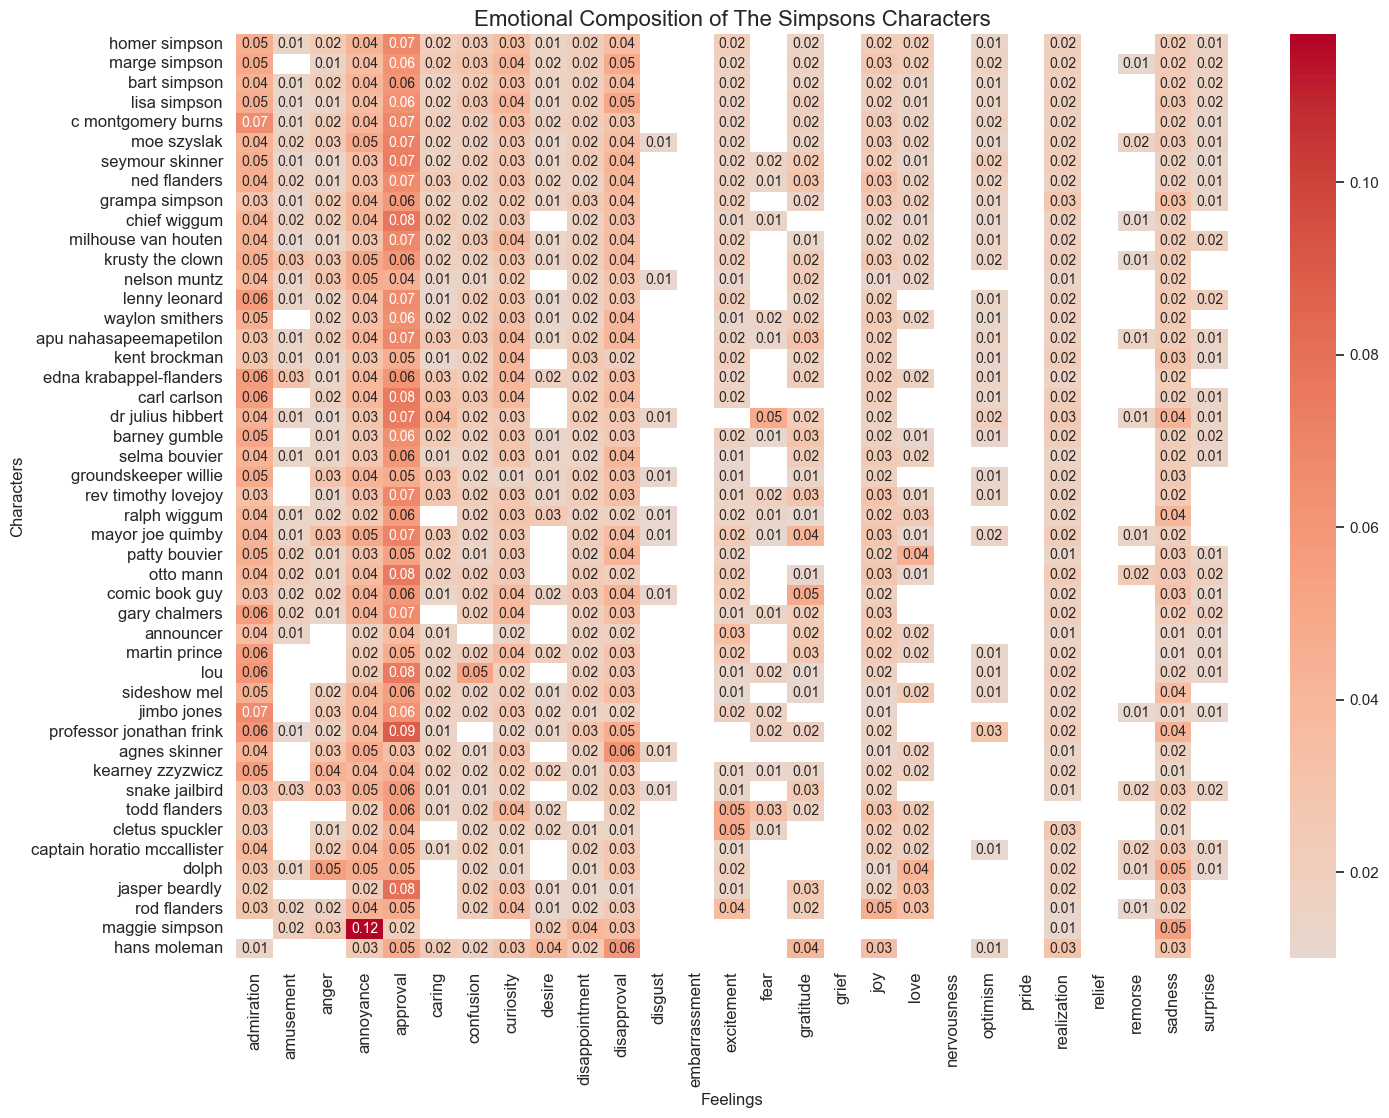

In [165]:
heatmap_mean_emotional_character.set_index('normalized_name', inplace=True)

# Filter with the condition value > 0.02
mask = (heatmap_mean_emotional_character < 0.01)

masked_data = heatmap_mean_emotional_character.mask(mask)

plt.figure(figsize=(16, 12))

sns.heatmap(masked_data, annot=True, annot_kws={"size": 10}, fmt=".2f", cmap='coolwarm', center=0)

plt.title('Emotional Composition of The Simpsons Characters', fontsize=16)
plt.xlabel('Feelings')
plt.ylabel('Characters')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [60]:


def ridge_plot(character_id, emotions_to_include):
    # Establecer el tema y el estilo global de seaborn
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    # Filtrar el DataFrame por el personaje y emociones deseadas
    filter_mean_emotional_lines_per_season = mean_emotional_lines_per_season[mean_emotional_lines_per_season['normalized_name'] == character_id]
    filter_mean_emotional_lines_per_season = filter_mean_emotional_lines_per_season[filter_mean_emotional_lines_per_season['emotion'].isin(emotions_to_include)]

    filter_mean_emotional_lines_per_season['value'] = filter_mean_emotional_lines_per_season['value'] * 10000
    filter_mean_emotional_lines_per_season['value'] = filter_mean_emotional_lines_per_season['value'].round(0).astype(int)

    # Reemplazar valores 'inf' por 'NaN'
    filter_mean_emotional_lines_per_season = filter_mean_emotional_lines_per_season.replace([np.inf, -np.inf], np.nan)
    # Eliminar filas con valores NaN en la columna 'value'
    filter_mean_emotional_lines_per_season.dropna(subset=['value'], inplace=True)
  
    # Repetir cada fila según el valor en la columna 'value'
    df_repeated = filter_mean_emotional_lines_per_season.loc[filter_mean_emotional_lines_per_season.index.repeat(filter_mean_emotional_lines_per_season['value'])]
    df_repeated.reset_index(drop=True, inplace=True)
    df_repeated.drop('value', axis=1, inplace=True)

    # Crear una paleta personalizada más intensa basada en "coolwarm"
    custom_cmap = sns.color_palette("coolwarm", as_cmap=True)
    n_colors = len(emotions_to_include)
    new_palette = []
    for i in range(n_colors):
        color = custom_cmap(i / (n_colors - 1))
        new_color = (color[0] ** 1.1, color[1] ** 1.1, color[2] ** 1.1)  # Elevar al cubo para intensificar más
        new_palette.append(new_color)
    pal = sns.color_palette(new_palette, n_colors=len(emotions_to_include))
    pal = pal[::-1]  # Invertir el orden de la paleta


    # Inicializar el objeto FacetGrid
    g = sns.FacetGrid(df_repeated, row="emotion", hue="emotion", aspect=16, height=0.7, palette=pal, row_order=emotions_to_include, hue_order=emotions_to_include)

    # Dibujar las densidades en varios pasos
    g.map(sns.kdeplot, "season", bw_adjust=.5, clip_on=False, fill=True, alpha=0.75, linewidth=1.5)
    g.map(sns.kdeplot, "season", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # Usar el mapeo de color para refline()
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Definir y usar una función simple para etiquetar el gráfico
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="bottom", transform=ax.transAxes)

    g.map(label, "season")

    plt.xticks(range(1, 23))
    
    # Ajustar el espaciado entre subplots
    g.figure.subplots_adjust(hspace=-0.4)

    # Agregar un título al gráfico
    g.fig.suptitle(f"Feelings over Season of {character_id.title()}", fontsize=16, fontweight='bold', y=1.05)

    # Eliminar detalles de los ejes innecesarios
    g.set_titles('')
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Mostrar el gráfico
    plt.show()
    return df_repeated



#### 

In [61]:

def create_character_emotional_analysis(character_name, emotions):
    num_top_bottom = int(emotions / 2)

    character_id = character_df.loc[character_df['normalized_name'] == character_name, 'id'].values[0]
    
    emotional_ids = script_lines_df.loc[script_lines_df['character_id'] == character_id, 'emotional_id'].unique()
    
    character_emotional_lines_df = emotional_lines_df[emotional_lines_df['emotional_id'].isin(emotional_ids)]
    
    character_emotional_lines_df = pd.merge(character_emotional_lines_df, script_lines_df[['emotional_id', 'episode_id']], on='emotional_id', how='inner')
    
    character_emotional_lines_df.drop('emotional_id', axis=1, inplace=True)
    
    character_emotional_lines_df = character_emotional_lines_df.groupby('episode_id').mean().reset_index()
    
    character_emotional_lines_df = pd.merge(character_emotional_lines_df, episode_df[['id', 'imdb_rating']], left_on='episode_id', right_on='id', how='inner')
    
    character_emotional_lines_df.drop('id', axis=1, inplace=True)
    
    if 'neutral' in character_emotional_lines_df.columns:
        character_emotional_lines_df.drop('neutral', axis=1, inplace=True)

    columns_to_compare = character_emotional_lines_df.columns.difference(['episode_id', 'imdb_rating'])
    correlation_df = pd.DataFrame()
    correlation_df['episodes_correlation'] = character_emotional_lines_df[columns_to_compare].corrwith(character_emotional_lines_df['episode_id'])
    correlation_df['imdb_rating_correlation'] = character_emotional_lines_df[columns_to_compare].corrwith(character_emotional_lines_df['imdb_rating'])
    correlation_df = correlation_df.sort_values(by='episodes_correlation', ascending=False)

    top_high = correlation_df.head(num_top_bottom)
    top_low = correlation_df.tail(num_top_bottom)

    selected_rows = pd.concat([top_high, top_low])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

    sns.heatmap(selected_rows, cmap='coolwarm', annot=True, ax=axes[0])
    axes[0].set_title(f'Correlation heatmap of Emotions for {character_name.title()}')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=12)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=12)

    episode_id_values = selected_rows['episodes_correlation']
    imdb_rating_values = selected_rows['imdb_rating_correlation']
    labels = selected_rows.index

    sns.scatterplot(x=episode_id_values, y=imdb_rating_values, color='blue', alpha=0.5, ax=axes[1])
    axes[1].set_title(f'Correlations of episodes vs imdb_rating for {character_name.title()}')
    axes[1].set_xlabel('episodes_correlation')
    axes[1].set_ylabel('imdb_rating_correlation')

    axes[1].axhline(0, color='black', linewidth=0.5)
    axes[1].axvline(0, color='black', linewidth=0.5)

    texts = [axes[1].text(episode_id_values.iloc[i], imdb_rating_values.iloc[i], labels[i], fontsize=12) for i in range(len(labels))]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

    plt.tight_layout()
    plt.show()
    
    emotions_to_plot = list(selected_rows.index)
    
    ridge_plot(character_name, emotions_to_plot)

#### Here we will see the emotions that change the most inside the characters that change the most.

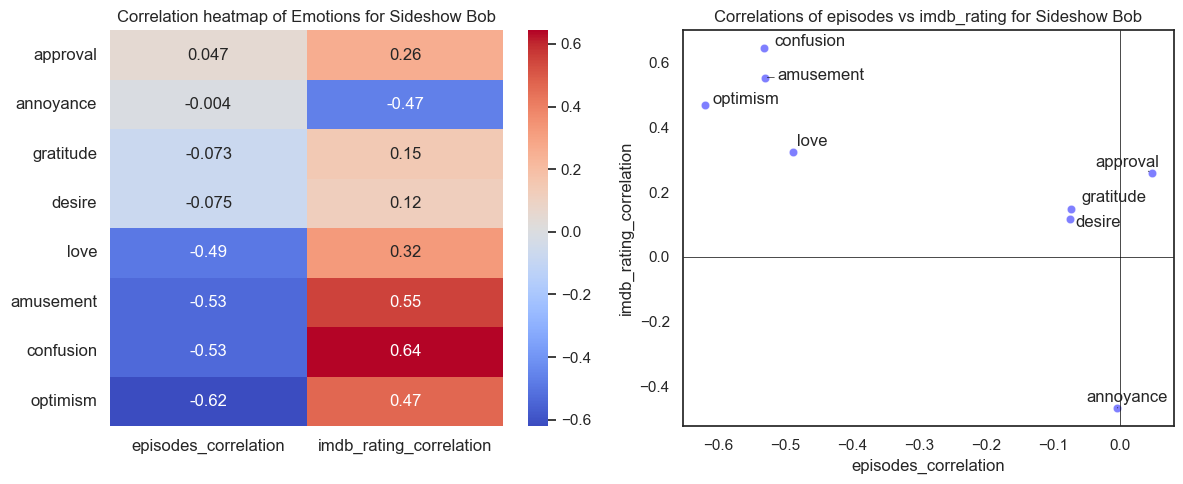

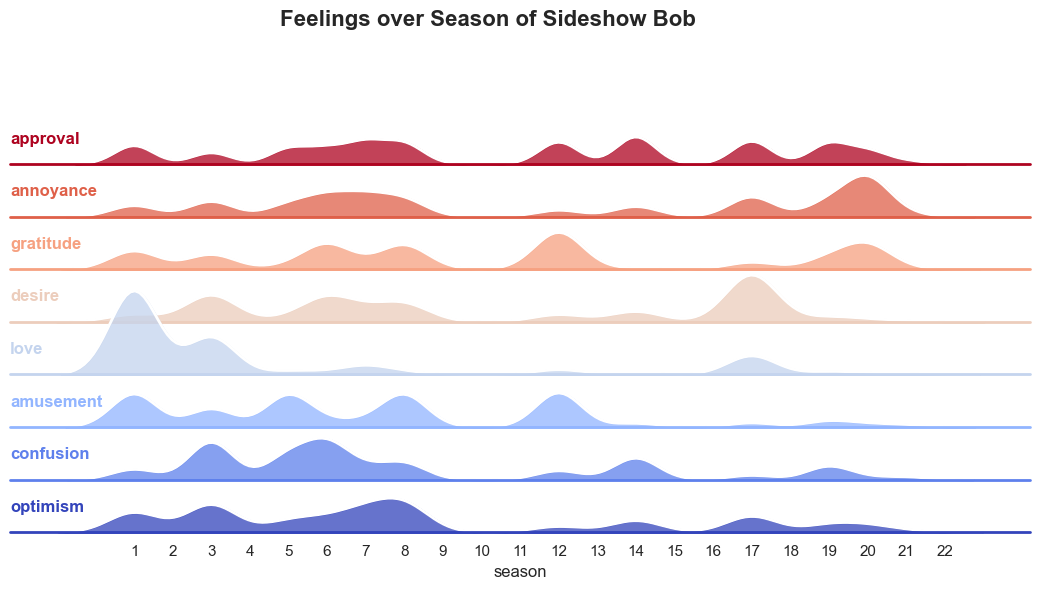

In [62]:
character_name = 'sideshow bob'

create_character_emotional_analysis(character_name, emotions = 8)

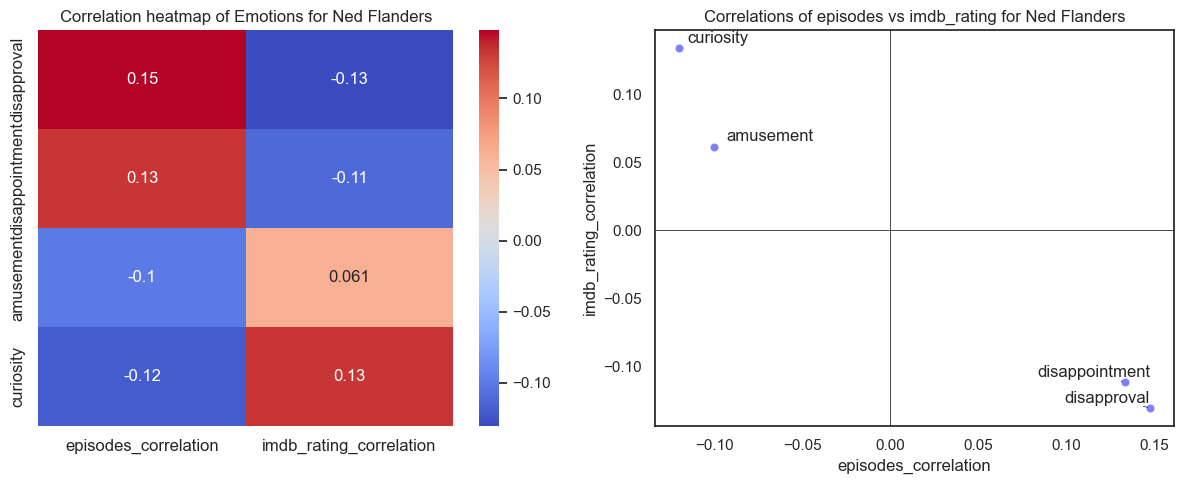

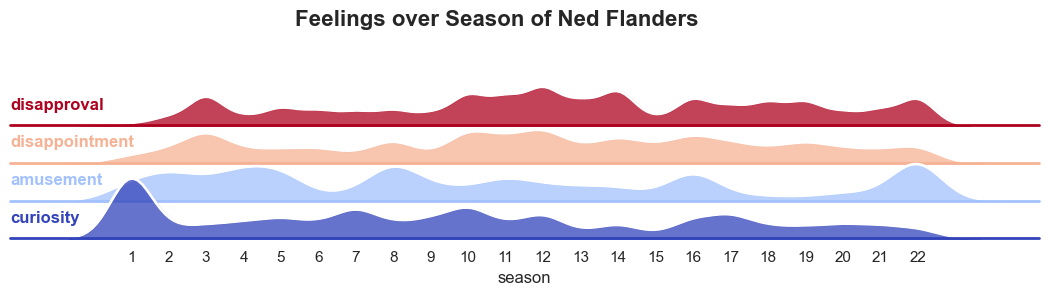

In [63]:
character_name = 'ned flanders'

create_character_emotional_analysis(character_name, emotions = 4)

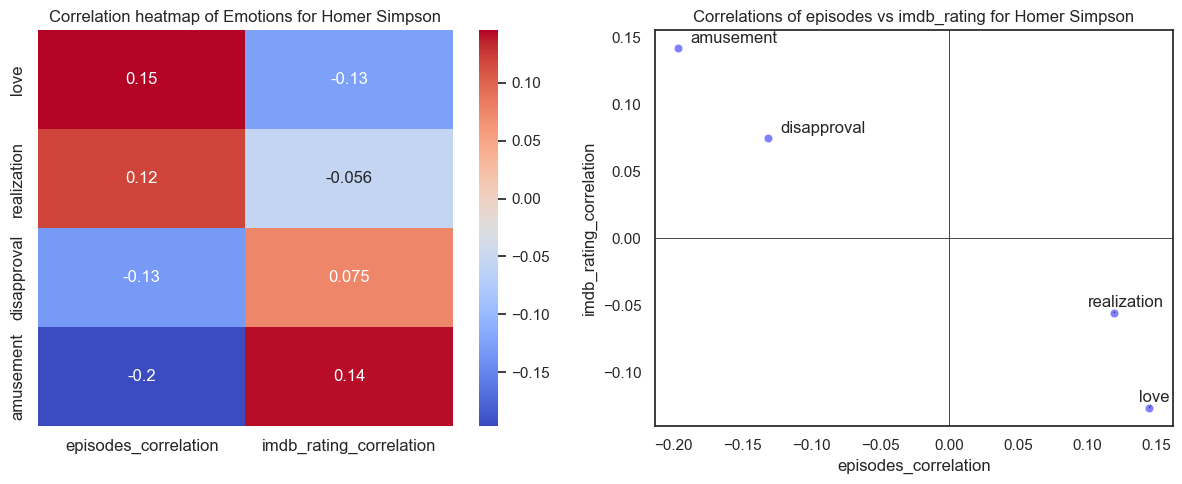

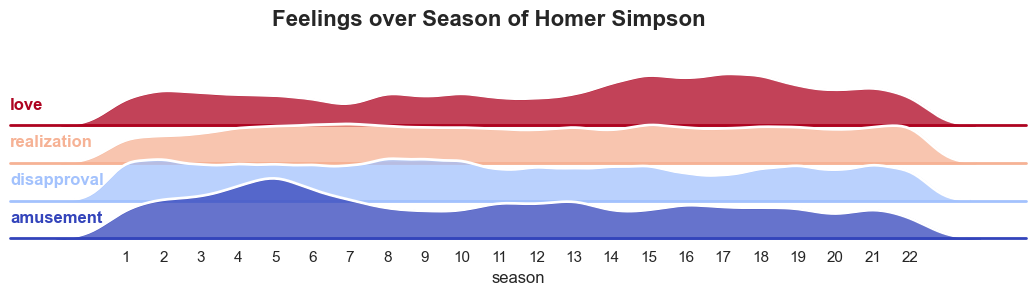

In [64]:
character_name = 'homer simpson'

create_character_emotional_analysis(character_name, emotions = 4)

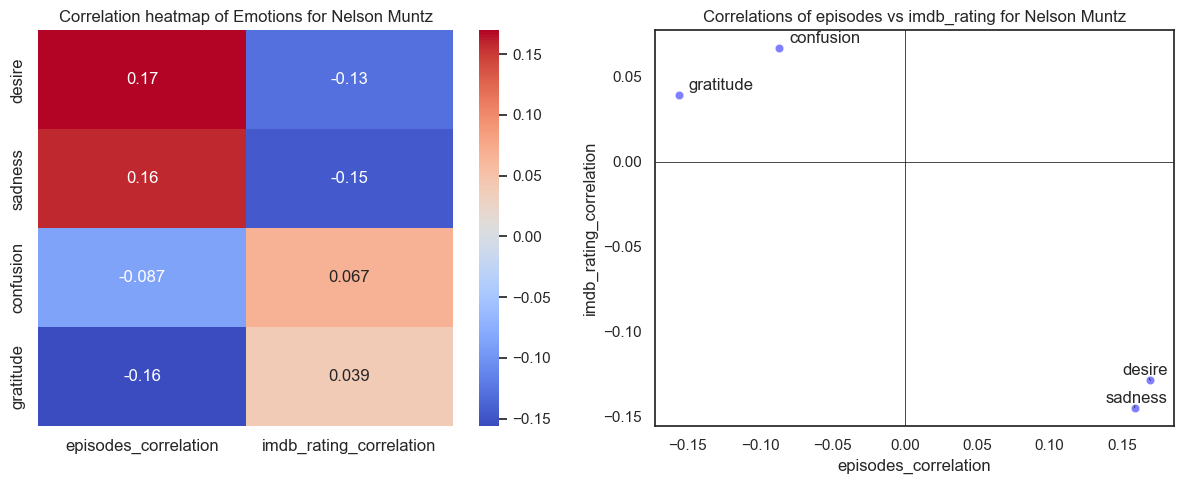

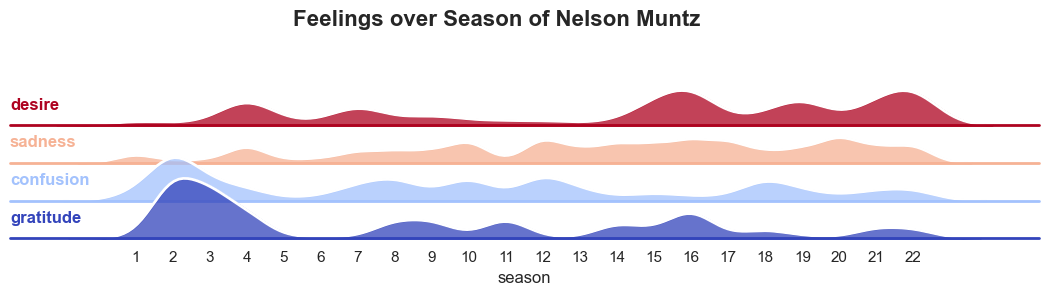

In [65]:
character_name = 'nelson muntz'

create_character_emotional_analysis(character_name, emotions = 4)

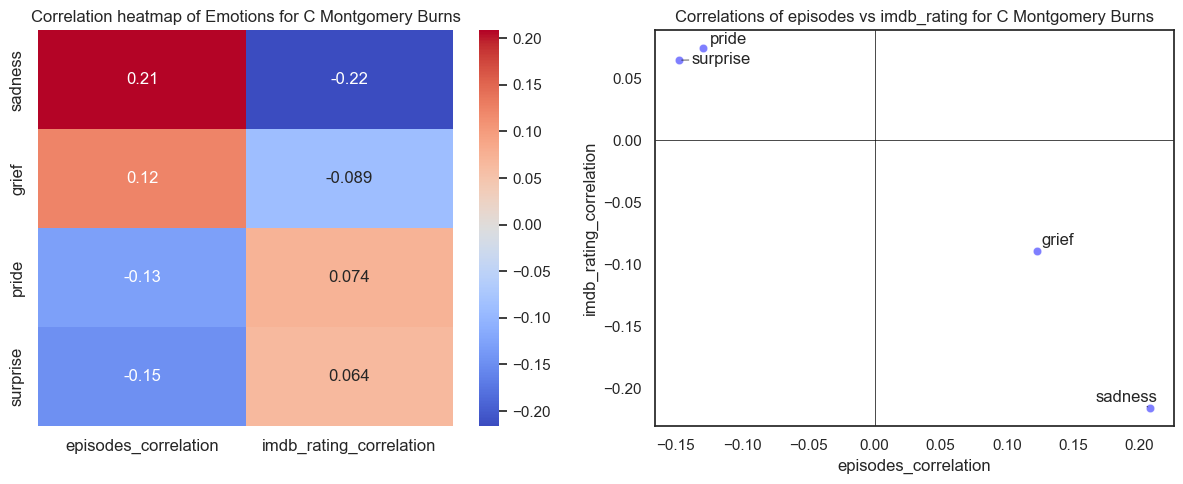

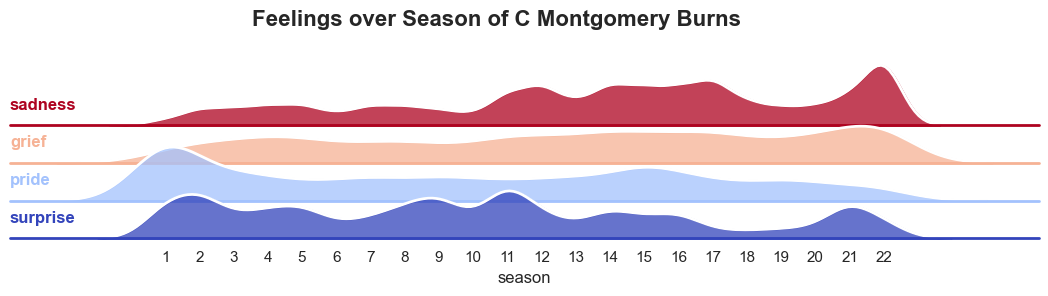

In [66]:
character_name = 'c montgomery burns'

create_character_emotional_analysis(character_name, emotions = 4)

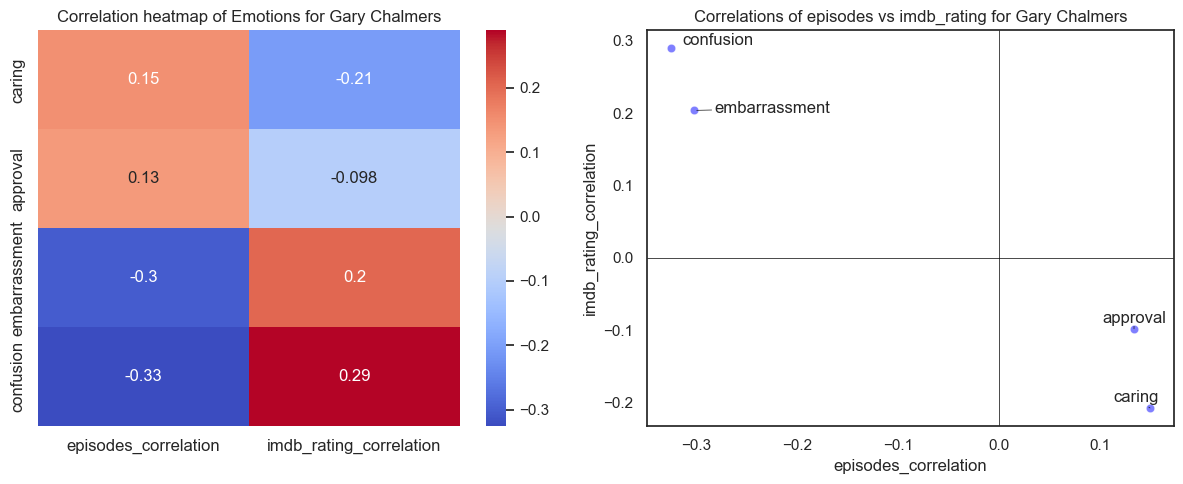

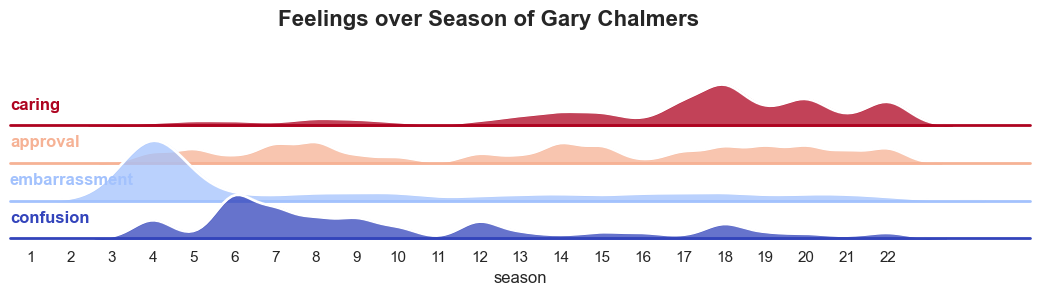

In [67]:
character_name = 'gary chalmers'

create_character_emotional_analysis(character_name, emotions = 4)

### ok now we are going to try another model that checks a binomial result (positive lines o negative lines) from de lines of the show and see if during the episodes goes by some character they might change in this aspect.

### - List of witch character has the most sentimental feelings

In [68]:


melt_emotional_lines_df =  emotional_lines_df.melt(id_vars=['emotional_id'],value_vars=emotions_list, var_name= 'emotion', value_name='value')

highest_characters_emotions_values = melt_emotional_lines_df.merge(script_lines_df[['emotional_id', 'character_id']], on='emotional_id', how='left')
highest_characters_emotions_values = highest_characters_emotions_values.merge(character_df[['id', 'normalized_name']],left_on='character_id', right_on='id',how='left')

highest_characters_emotions_values.drop(['id','emotional_id','character_id'], axis=1, inplace=True)

highest_characters_emotions_values = highest_characters_emotions_values[highest_characters_emotions_values['normalized_name'].isin(list_main_characters)]
highest_characters_emotions_values.reset_index(drop=True, inplace=True)

highest_characters_emotions_values = highest_characters_emotions_values.groupby(['normalized_name','emotion'], as_index=False).mean()

idx = highest_characters_emotions_values.groupby(['emotion'])['value'].transform(max) == highest_characters_emotions_values['value']

df_highest_values = highest_characters_emotions_values[idx]

df_highest_values = df_highest_values[df_highest_values['emotion'] != 'neutral']

new_order_columns = ['normalized_name','emotion','value']

df_highest_values = df_highest_values[new_order_columns]

df_highest_values.sort_values(by= 'normalized_name')


melt_emotional_lines_df

C:\Users\ltf-g\AppData\Local\Temp\ipykernel_10184\3620089036.py:13: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = highest_characters_emotions_values.groupby(['emotion'])['value'].transform(max) == highest_characters_emotions_values['value']


emotional_id     emotion     value
0               86263  admiration  0.408298
1               86264  admiration  0.011222
2               86265  admiration  0.002540
3               86266  admiration  0.001544
4               86267  admiration  0.005703
...               ...         ...       ...
3698179         86255    surprise  0.001222
3698180         86256    surprise  0.001391
3698181         86257    surprise  0.001212
3698182         86258    surprise  0.001342
3698183         86259    surprise  0.006503

[3698184 rows x 3 columns]

In [69]:
binomial_emotion_result = pd.read_csv(r'cvs_files\emotional_binomial_result.csv')
binomial_emotion_result.head(2)


emotional_id                                    normalized_text     label  \
0       86263.0  im sorry everyone i perpetrated this charade t...  POSITIVE   
1       86264.0                                              awwww  NEGATIVE   

      score  positive_result  
0  0.998435         0.998435  
1  0.982339         0.017661

In [70]:
binomial_emotion_result_merge = pd.merge(binomial_emotion_result, script_lines_df[['emotional_id','episode_id','season', 'character_id',]],
                                   left_on= 'emotional_id', right_on='emotional_id', how='left')


binomial_emotion_result_merge = pd.merge(binomial_emotion_result_merge,
                                   character_df[['id', 'normalized_name']],
                                   left_on='character_id',
                                   right_on='id',
                                   how='left')


binomial_emotion_result_merge.drop('id', axis=1, inplace=True)


binomial_emotion_result_merge = pd.merge(binomial_emotion_result_merge,
                                   episode_df[['id', 'imdb_rating']],
                                   left_on='episode_id',
                                   right_on='id',
                                   how='left')

binomial_emotion_result_merge.drop('id', axis=1, inplace=True)

In [71]:
binomial_emotion_result_merge.head(5)

emotional_id                                    normalized_text     label  \
0       86263.0  im sorry everyone i perpetrated this charade t...  POSITIVE   
1       86264.0                                              awwww  NEGATIVE   
2       86265.0           seymour your feelings are ugly and wrong  NEGATIVE   
3       86266.0                        are you gonna listen to her  POSITIVE   
4       86267.0  not on your life reverend from now on im my ow...  NEGATIVE   

      score  positive_result  episode_id  season  character_id  \
0  0.998435         0.998435       298.0    14.0           3.0   
1  0.982339         0.017661       298.0    14.0         321.0   
2  0.998243         0.001757       298.0    14.0         192.0   
3  0.997690         0.997690       298.0    14.0        3745.0   
4  0.997298         0.002702       298.0    14.0           3.0   

   normalized_name  imdb_rating  
0  seymour skinner          7.1  
1         audience          7.1  
2    agnes skinner          7.1  
3   little richard          7.1  
4  seymour skinner          7.1

In [72]:
grouped_mean = binomial_emotion_result_merge.groupby(['episode_id', 'imdb_rating'])['positive_result'].mean().reset_index()

episode_r, episode_p_value = pearsonr(grouped_mean['episode_id'], grouped_mean['positive_result'])
episode_r_squared = episode_r**2

episode_p_value_significant = episode_p_value < 0.05

print(f"Pearson correlation (r) between 'episode_id' and 'positive_commets': {episode_r:.4f}")
print(f"r-squared (r^2) value: {episode_r_squared:.4f}")
print(f"P-value: {episode_p_value:.4f}")

Pearson correlation (r) between 'episode_id' and 'positive_commets': -0.1674
r-squared (r^2) value: 0.0280
P-value: 0.0002


In [176]:
grouped_mean = binomial_emotion_result_merge.groupby(['episode_id', 'imdb_rating'])['positive_result'].mean().reset_index()

episode_r, episode_p_value = pearsonr(grouped_mean['imdb_rating'], grouped_mean['positive_result'])
episode_r_squared = episode_r**2

episode_p_value_significant = episode_p_value < 0.05

print(f"Pearson correlation (r) between 'imdb_rating' and 'positive_commets': {episode_r:.4f}")
print(f"r-squared (r^2) value: {episode_r_squared:.4f}")
print(f"P-value: {episode_p_value:.4f}")

Pearson correlation (r) between 'imdb_rating' and 'positive_commets': -0.0169
r-squared (r^2) value: 0.0003
P-value: 0.7107


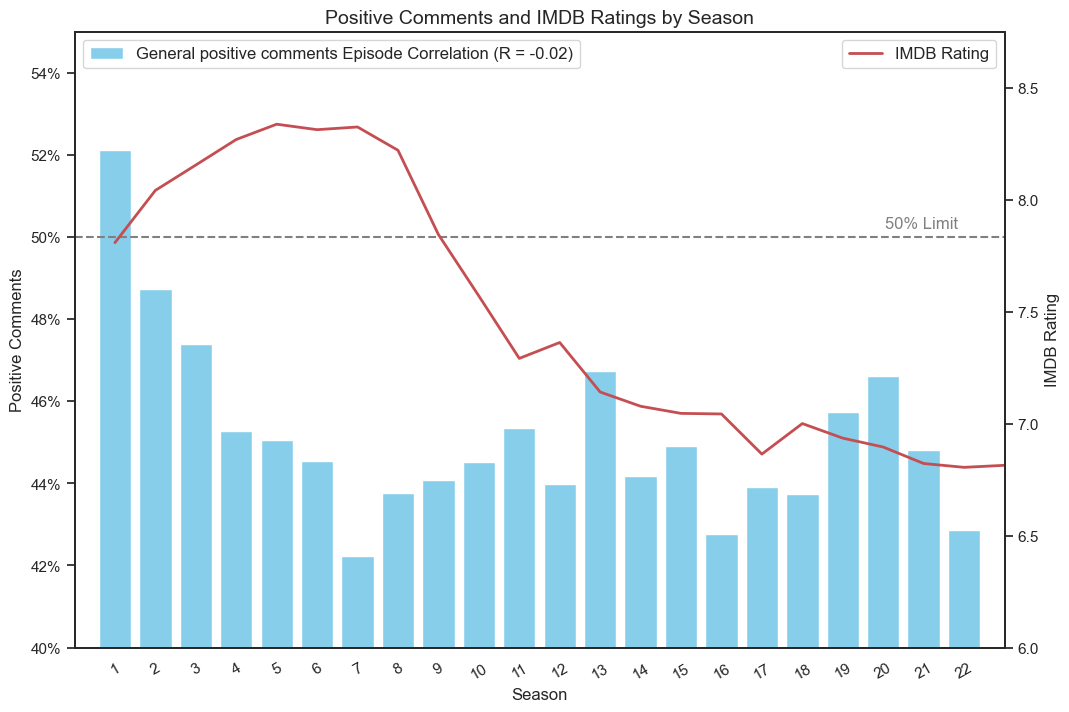

In [177]:
positive_coments_groupby_seasons = binomial_emotion_result_merge.groupby('season')['positive_result'].mean().reset_index()

seasons = positive_coments_groupby_seasons['season']
positive_means = positive_coments_groupby_seasons['positive_result']

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(seasons, positive_means, color='skyblue', label='Positive Comments')
ax.set_title('Positive Comments and IMDB Ratings by Season', fontsize=14)
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Positive Comments', fontsize=12)

ax.set_ylim(0.4, 0.55)
ax.set_xticks(np.arange(1, 23, 1))
ax.tick_params(axis='x', rotation=30)

legend_text = f'General positive comments Episode Correlation (R = {episode_r:.2f})'
ax.legend([legend_text], loc='upper left', fontsize=12, facecolor='white')

def percentage(x, pos):
    return f'{x*100:.0f}%'
ax.yaxis.set_major_formatter(plt.FuncFormatter(percentage))

ax.axhline(y=0.5, color='gray', linestyle='--')
ax.text(0.95, 0.68, '50% Limit', color='gray', ha='right', transform=ax.transAxes, fontsize=12)

average_ratings = episode_df.groupby('season')['imdb_rating'].mean()

ax2 = ax.twinx() 

ax2.plot(average_ratings.index, average_ratings.values, linestyle='-', color='r', linewidth=2, label='IMDB Rating')
ax2.set_ylabel('IMDB Rating', fontsize=12)
ax2.set_ylim(6, 8.75)
ax2.set_xlim(0, 23)

ax2.legend(loc='upper right', fontsize=12, facecolor='white')

plt.show()


In [74]:
grouped_mean_rating = binomial_emotion_result_merge.groupby('imdb_rating')['positive_result'].mean().reset_index()

rating_r, rating_p_value = pearsonr(grouped_mean_rating['imdb_rating'], grouped_mean_rating['positive_result'])
rating_r_squared = rating_r**2

rating_p_value_significant = rating_p_value < 0.05

print(f"Pearson correlation (r) between 'imdb_rating' and 'positive_commets': {rating_r:.4f}")
print(f"r-squared (r^2) value: {rating_r_squared:.4f}")
print(f"P-value: {rating_p_value:.4f}")


Pearson correlation (r) between 'imdb_rating' and 'positive_commets': -0.2545
r-squared (r^2) value: 0.0648
P-value: 0.1284


In [75]:
def calculate_pearson_correlations(df, list_main_characters):

    correlation_results = []

    for character in list_main_characters:
        
        filter_binomial_emotion_result = df[df['normalized_name'] == character]

        avg_positive_result_by_episode = filter_binomial_emotion_result.groupby('episode_id')['positive_result'].mean().reset_index()


        r, p_value = pearsonr(avg_positive_result_by_episode['episode_id'], avg_positive_result_by_episode['positive_result'])
        r_squared = r**2

        p_value_significant = p_value < 0.01

        correlation_results.append({'character': character, 'r': r, 'r^2': r_squared, 'p_value': p_value, 'p_value_significant': p_value_significant})

    correlation_df = pd.DataFrame(correlation_results)

    return correlation_df

In [76]:

correlation_results = calculate_pearson_correlations(binomial_emotion_result_merge, list_main_characters)

correlation_results.sort_values(by= 'r')

character         r       r^2   p_value  \
27               maggie simpson -0.277867  0.077210  0.505196   
12            dr julius hibbert -0.225130  0.050684  0.002311   
45                todd flanders -0.215698  0.046526  0.086936   
26                          lou -0.212775  0.045273  0.019123   
40                 rod flanders -0.198730  0.039493  0.142022   
35                    otto mann -0.198433  0.039375  0.029809   
2        apu nahasapeemapetilon -0.175791  0.030903  0.021457   
5            c montgomery burns -0.173539  0.030116  0.012396   
28                marge simpson -0.156981  0.024643  0.000542   
23             krusty the clown -0.139854  0.019559  0.044970   
6   captain horatio mccallister -0.129391  0.016742  0.289315   
4                  bart simpson -0.109777  0.012051  0.015903   
21             kearney zzyzwicz -0.104999  0.011025  0.306049   
18                homer simpson -0.101380  0.010278  0.025879   
8                  chief wiggum -0.086094  0.007412  0.161473   
46              waylon smithers -0.060871  0.003705  0.451807   
38                 ralph wiggum -0.058959  0.003476  0.460383   
25                 lisa simpson -0.054660  0.002988  0.231478   
42              seymour skinner -0.046542  0.002166  0.455782   
0                 agnes skinner -0.038174  0.001457  0.736733   
20                  jimbo jones -0.033822  0.001144  0.733218   
1                     announcer -0.033696  0.001135  0.662675   
7                  carl carlson -0.033572  0.001127  0.610939   
16         groundskeeper willie -0.019807  0.000392  0.815660   
31          milhouse van houten -0.019146  0.000367  0.755492   
24                lenny leonard -0.017400  0.000303  0.777176   
9               cletus spuckler -0.014280  0.000204  0.902555   
32                  moe szyslak -0.011788  0.000139  0.833625   
30             mayor joe quimby -0.010529  0.000111  0.908745   
10               comic book guy -0.010428  0.000109  0.917154   
11                        dolph  0.005880  0.000035  0.965691   
41                selma bouvier  0.007356  0.000054  0.944521   
33                 ned flanders  0.008992  0.000081  0.889552   
19               jasper beardly  0.019357  0.000375  0.882287   
15               grampa simpson  0.031120  0.000968  0.645431   
34                 nelson muntz  0.047398  0.002247  0.467694   
36                patty bouvier  0.068000  0.004624  0.514904   
3                 barney gumble  0.080601  0.006497  0.303412   
44               snake jailbird  0.080679  0.006509  0.503597   
29                martin prince  0.091172  0.008312  0.350325   
39          rev timothy lovejoy  0.092361  0.008531  0.332761   
13      edna krabappel-flanders  0.111465  0.012424  0.233565   
43                 sideshow mel  0.114497  0.013110  0.213048   
37     professor jonathan frink  0.120729  0.014575  0.302183   
17                 hans moleman  0.160572  0.025784  0.275604   
22                kent brockman  0.178271  0.031780  0.010547   
14                gary chalmers  0.300869  0.090522  0.010787   

    p_value_significant  
27                False  
12                 True  
45                False  
26                False  
40                False  
35                False  
2                 False  
5                 False  
28                 True  
23                False  
6                 False  
4                 False  
21                False  
18                False  
8                 False  
46                False  
38                False  
25                False  
42                False  
0                 False  
20                False  
1                 False  
7                 False  
16                False  
31                False  
24                False  
9                 False  
32                False  
30                False  
10                False  
11                False  
41                False  
33                False  
19               

In [77]:
select_character_for_binomial_graph = correlation_results[correlation_results['p_value_significant'] == True]

select_character_for_binomial_graph = select_character_for_binomial_graph.sort_values(by='r')

list_select_characters_for_binomial_graph = select_character_for_binomial_graph['character'].to_list()

list_select_characters_for_binomial_graph

['dr julius hibbert', 'marge simpson']

In [78]:
def plot_bar_chart(list_select_characters_for_binomial_graph, binomial_emotion_result, correlation_results):
    num_plots = len(list_select_characters_for_binomial_graph)
    num_rows = 4
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))

    for i, character in enumerate(list_select_characters_for_binomial_graph):
    
        row = i // num_cols
        col = i % num_cols

        filter_result = binomial_emotion_result[binomial_emotion_result['normalized_name'] == character]

        avg_positive_by_season = filter_result.groupby('season')['positive_result'].mean().reset_index()

        seasons = avg_positive_by_season['season']

        positive_means = avg_positive_by_season['positive_result']

        axes[row, col].bar(seasons, positive_means, color='skyblue')
        axes[row, col].set_title(f'Positive comments for {character}', fontsize=12)

        x_ticks = np.arange(1, 23, 1)
        axes[row, col].set_xticks(x_ticks)
        axes[row, col].set_ylim(0.15, 0.7)

        axes[row, col].set_xlabel('Season', fontsize=10)
        axes[row, col].set_ylabel('Positive comments', fontsize=10)

        axes[row, col].tick_params(axis='x', rotation=30)

        def percentage(x, pos):
            return f'{x*100:.0f}%'
        axes[row, col].yaxis.set_major_formatter(plt.FuncFormatter(percentage))

        if character in correlation_results['character'].values:
            corr_row = correlation_results[correlation_results['character'] == character].iloc[0]
            r_value = corr_row['r']
            r_squared_value = corr_row['r^2']
            axes[row, col].set_title(f'Positive comments for {character}\nCorrelation R: {r_value:.2f}, R^2: {r_squared_value:.4f}', fontsize=12)
        else:
            axes[row, col].set_title(f'Positive comments for {character}', fontsize=12)
            
    for ax in axes.flat:
        ax.axhline(y=0.5, color='gray', linestyle='--')
        ax.text(0.95, 0.65, '50% limit', color='gray', ha='right', transform=ax.transAxes)


    for j in range(num_plots, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        fig.delaxes(axes[row, col])


    fig.tight_layout()
    plt.show()  

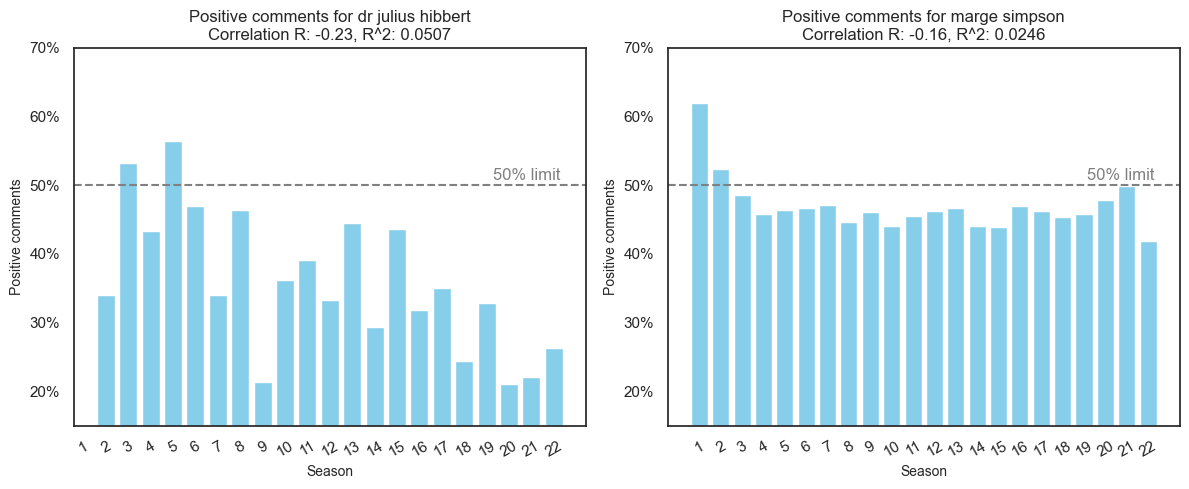

In [79]:
plot_bar_chart(list_select_characters_for_binomial_graph,binomial_emotion_result_merge,correlation_results)

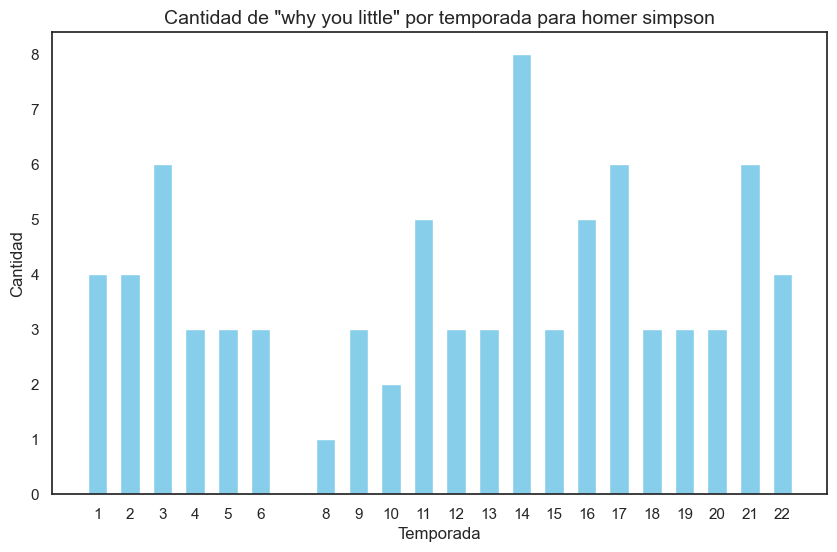

In [80]:
def catch_phrase_count_seasons(character, text):
    character_id = character_df[character_df['normalized_name'] == character]['id'].iloc[0]

    filter_df = script_lines_df[(script_lines_df['character_id'] == character_id) & (script_lines_df['normalized_text'].str.contains(text, case=False))]

    catch_phrase = filter_df.groupby('season').size().reset_index(name='count')

    plt.figure(figsize=(10, 6), facecolor='white')

    plt.bar(catch_phrase['season'], catch_phrase['count'], color='skyblue', width=0.6, align='center')

    plt.title(f'Cantidad de "{text}" por temporada para {character}', fontsize=14)
    plt.xlabel('Temporada', fontsize=12)
    plt.ylabel('Cantidad', fontsize=12)

    plt.xticks(catch_phrase['season'])

    plt.show()
catch_phrase_count_seasons('homer simpson','why you little')

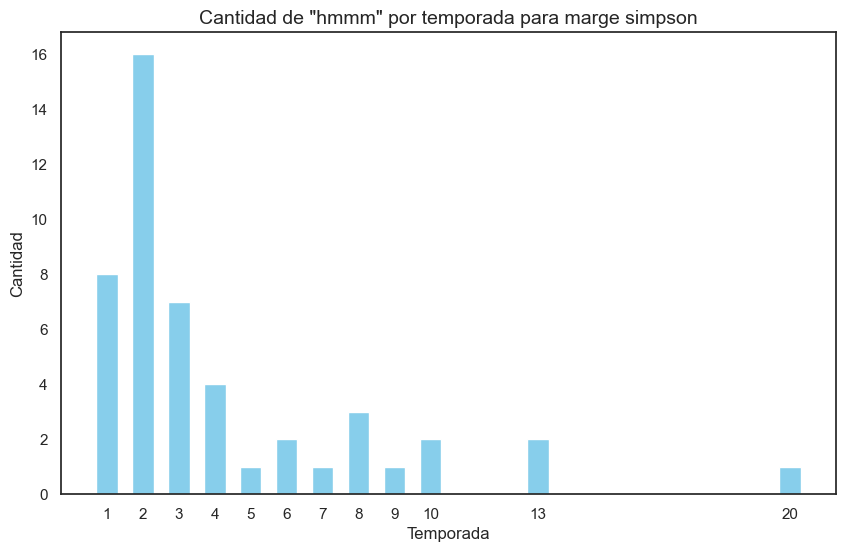

In [81]:
catch_phrase_count_seasons('marge simpson','hmmm')